# MMM Calibration with Geo-Level Lift Tests

## Introduction

This notebook demonstrates how to calibrate a multidimensional MMM using lift test results from a geo-level experiment. By incorporating experimental lift measurements, we can achieve better parameter recovery--both reduced bias and increased precision--compared to fitting the MMM alone.

We follow the same pattern as the [national-level lift test notebook](mmm_lift_test.ipynb), generating data directly from the model to ensure perfect consistency.

### Notebook Overview

This is a long technical document, so here's a roadmap of what we'll cover:

**Setup (Sections 1-2)**
- We simulate a marketing dataset with **8 geographic regions** and **2 media channels**
- The two channels are highly correlated (~0.99), making them difficult to separate--a common real-world challenge

**The Experiment (Section 3)**
- We run a geo-level lift test on **channel 1 only**
- **4 treated geos** receive an incremental spend increase; **4 control geos** remain unchanged
- This produces **4 lift test measurements**--one per treated geo--each estimating the causal effect of channel 1

**Analysis (Sections 4-6)**
- We fit the MMM twice: once without calibration (baseline) and once with lift test calibration
- We compare parameter recovery, showing that calibration reduces bias and increases precision
- Key result: the calibrated model's saturation curves more closely match the true curves

### When to Use Geo-Level Lift Tests

Geo-level lift tests are appropriate when you can:
- **Target specific geographic regions**: Digital campaigns with location targeting, regional TV markets
- **Hold out control regions**: Some geos receive the treatment while others serve as controls
- **Measure regional outcomes**: Sales, conversions, or other metrics at the geographic level

### The Practical Workflow: From Experiment to Calibration

In practice, running a geo-level lift test and using it to calibrate an MMM involves several steps:

1. **Design and run the experiment**: Increase (or decrease) spend on one channel in a subset of geographic regions (treated geos), while keeping spend unchanged in the remaining regions (control geos). Run the experiment for several weeks.

2. **Analyze the experiment with synthetic control**: Use a method like [CausalPy's multi-cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html) to estimate the causal effect. Synthetic control constructs a weighted combination of control geos that matches each treated geo's pre-experiment trend, then measures the post-experiment divergence as the treatment effect.

3. **Extract lift test measurements**: From the CausalPy analysis, obtain for each treated geo:
   - x: the baseline spend level during the test period
   - delta_x: the incremental spend change applied
   - delta_y: the estimated causal lift in outcomes
   - sigma: the uncertainty (standard error) of the lift estimate

4. **Calibrate the MMM**: Pass these lift test measurements to the MMM's add_lift_test_measurements() method to constrain the saturation curve parameters during model fitting.

**Scope of this notebook**: This notebook focuses on step 4--demonstrating how lift test measurements improve MMM parameter recovery. We simulate the lift test results directly rather than running a full CausalPy analysis, since this is a PyMC-Marketing tutorial. For the experiment analysis step, see the [CausalPy documentation](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html).

### Why Lift Tests Work: Pinning Down the Saturation Curve

It's worth understanding *why* lift tests improve parameter estimation--the benefit goes beyond simply adding more variation to your data.

**The problem with observational data alone**

When fitting an MMM to observational data, you observe spend (X) and outcomes (Y) moving together. But correlation isn't causation:
- Maybe sales rise when spend rises because the spend *caused* more sales
- Or maybe both rose because of an external factor (seasonality, promotions, economic conditions)
- With highly correlated channels, the model can't tell which channel is actually driving sales--many different parameter combinations fit the data equally well

**What a lift test provides: causal ground truth**

A lift test is an *experiment*. By randomly assigning some geos to receive increased spend while others serve as controls, the difference in outcomes between groups is a **causal effect**, not just a correlation. The lift test tells you:

> "When we increased channel 1 spend from x to x + delta_x, the true causal lift in sales was delta_y"

This is a point on the saturation curve that we *know* to be correct, not just inferred from correlational patterns.

**How calibration uses this information**

When we add lift test measurements to the MMM, we're adding a constraint that says: the model's saturation curve must pass through (or near) the experimentally measured point. Mathematically:

$$\text{saturation}(x + \Delta x) - \text{saturation}(x) \approx \Delta y$$

This pins down the saturation curve at the operating point where the experiment was run, dramatically reducing the set of feasible (lambda, beta) parameter values.

**The key distinction**

| Aspect | More Spend Variation | Lift Test Calibration |
|--------|----------------------|----------------------|
| **Provides** | More data points | Causal ground truth |
| **Helps with** | Precision (narrower posteriors) | Accuracy (reduced bias) |
| **Addresses** | Uncertainty in parameters | Bias in parameters |

In short: more data variation helps you estimate parameters more precisely, but a lift test helps you estimate the *right* parameters.

### Key Design Principles

1. **Normalized data**: Channel spend is normalized to [0, 1] range for consistent saturation behavior
2. **Model-based data generation**: We use `pm.do` and `pm.draw` to generate synthetic data from the model itself, ensuring the data perfectly matches model assumptions
3. **Consistent lift tests**: Lift test measurements are calculated using the same saturation function the model uses

## Prepare Notebook

In [1]:
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.mmm.transformers import logistic_saturation

# warnings.filterwarnings("ignore", category=UserWarning)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.dpi"] = 100
az.style.use("arviz-darkgrid")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Set random seed for reproducibility
seed = sum(map(ord, "Geo lift tests for MMM calibration"))
rng = np.random.default_rng(seed)
print(f"Random seed: {seed}")

Random seed: 3155


## Generate Synthetic Data

Our data generation follows a two-step process that ensures perfect consistency between the synthetic data and model assumptions:

### Step 1: Manually Simulate Channel Spend (X)

We manually create the **input data** — the marketing spend decisions:
- `channel_1`, `channel_2`: Normalized spend values in [0, 1] range
- `date`: Time dimension (weekly data)
- `geo`: Geographic dimension

This represents **business decisions** that are external to the model. We intentionally create highly correlated channels to simulate the identification problem that lift tests help solve.

**Importantly, the lift test experiment is embedded in the data**: During the final 8 weeks (the experiment period), the 4 treated geos receive increased channel 1 spend. This mirrors what would happen in a real geo-level experiment.

### Step 2: Generate Outcomes from the Model (y)

We generate the **target variable** (sales/conversions) using `pm.do` and `pm.draw`:
1. Build the MMM with the spend data X (which includes the experiment)
2. Use `pm.do` to fix model parameters to known "true" values
3. Use `pm.draw` to sample y from the model

This approach ensures that y is generated **exactly as the model expects**, including:
- Adstock transformations applied correctly
- Saturation curves computed consistently
- Noise structure matching the model's likelihood
- Internal scaling handled properly
- **The causal effect of the experiment on outcomes** (treated geos will have higher y during the experiment period due to increased channel 1 spend)

**Why not generate y manually?** Manual generation (e.g., `y = intercept + beta * saturation(adstock(x)) + noise`) can introduce subtle mismatches with how the model actually computes predictions, leading to poor parameter recovery.

---

### Create Normalized Channel Spend Data

Following the national-level notebook, we normalize spend data to [0, 1] range. This ensures:
- Saturation parameters (lam) have intuitive values (e.g., 5-15)
- The model's internal scaling doesn't create mismatches
- Lift test measurements are consistent with model assumptions

In [3]:
# Define dimensions
n_dates = 104  # 2 years of weekly data
geos = [f"geo_{i:02d}" for i in range(8)]  # 8 geos for tractable computation
n_geos = len(geos)
channels = ["channel_1", "channel_2"]
n_channels = len(channels)

# Create date range
dates = pd.date_range(start="2022-01-03", periods=n_dates, freq="W-MON")

# Define lift test experiment parameters
# The experiment runs for the last 8 weeks of the dataset
experiment_weeks = 8
experiment_start_idx = n_dates - experiment_weeks
experiment_start_date = dates[experiment_start_idx]
experiment_end_date = dates[-1]

# Treatment assignment: alternating geos for balance
treated_geos = [geos[i] for i in [0, 2, 4, 6]]  # 4 treated geos
control_geos = [geos[i] for i in [1, 3, 5, 7]]  # 4 control geos
test_channel = "channel_1"

# Spend increase during experiment (on normalized 0-1 scale)
# This is the incremental spend applied to treated geos
delta_x_experiment = 0.15

print("Data dimensions:")
print(f"  Dates: {n_dates} weeks ({dates[0].date()} to {dates[-1].date()})")
print(f"  Geos: {n_geos}")
print(f"  Channels: {n_channels}")
print("\nLift test experiment:")
print(
    f"  Period: {experiment_start_date.date()} to {experiment_end_date.date()} ({experiment_weeks} weeks)"
)
print(f"  Test channel: {test_channel}")
print(f"  Treated geos: {treated_geos}")
print(f"  Control geos: {control_geos}")
print(f"  Spend increase (delta_x): {delta_x_experiment}")

Data dimensions:
  Dates: 104 weeks (2022-01-03 to 2023-12-25)
  Geos: 8
  Channels: 2

Lift test experiment:
  Period: 2023-11-06 to 2023-12-25 (8 weeks)
  Test channel: channel_1
  Treated geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']
  Control geos: ['geo_01', 'geo_03', 'geo_05', 'geo_07']
  Spend increase (delta_x): 0.15


In [4]:
# Generate normalized spend data (0-1 range)
# Channel 1 and 2 are highly correlated (the identification problem)
rows = []

for geo in geos:
    # Generate base spend pattern (shared across channels for correlation)
    base_spend = pm.draw(
        pm.Uniform.dist(lower=0.2, upper=1.0, size=n_dates), random_seed=rng
    )
    base_spend = base_spend / base_spend.max()  # Normalize to max=1

    # Add geo-specific scaling
    geo_scale = 0.7 + 0.3 * (geos.index(geo) / (n_geos - 1))  # 0.7 to 1.0

    # Check if this geo is in the treatment group
    is_treated = geo in treated_geos

    for i, date in enumerate(dates):
        # Channel 1: base pattern with small noise
        ch1 = base_spend[i] * geo_scale + rng.normal(0, 0.02)
        ch1 = np.clip(ch1, 0.1, 1.0)

        # Apply experiment: increase channel 1 spend in treated geos during experiment period
        if is_treated and i >= experiment_start_idx:
            ch1_baseline = ch1  # Store baseline for reference
            ch1 = ch1 + delta_x_experiment
            ch1 = np.clip(ch1, 0.1, 1.2)  # Allow slightly above 1.0 during experiment

        # Channel 2: highly correlated with channel 1 (shifted slightly)
        # Note: Channel 2 is NOT affected by the experiment
        ch2 = base_spend[i] * geo_scale * 0.95 + rng.normal(0, 0.02)
        ch2 = np.clip(ch2, 0.1, 1.0)

        rows.append(
            {
                "date": date,
                "geo": geo,
                "channel_1": ch1,
                "channel_2": ch2,
            }
        )

df = pd.DataFrame(rows)

# Verify normalization
print("Channel spend ranges:")
print(
    f"  Overall: channel_1=[{df['channel_1'].min():.3f}, {df['channel_1'].max():.3f}], "
    f"channel_2=[{df['channel_2'].min():.3f}, {df['channel_2'].max():.3f}]"
)

# Check experiment effect
experiment_mask = df["date"] >= experiment_start_date
treated_mask = df["geo"].isin(treated_geos)

pre_experiment_treated = df[~experiment_mask & treated_mask]["channel_1"].mean()
during_experiment_treated = df[experiment_mask & treated_mask]["channel_1"].mean()
during_experiment_control = df[experiment_mask & ~treated_mask]["channel_1"].mean()

print("\nExperiment verification (channel_1):")
print(f"  Pre-experiment (treated geos): {pre_experiment_treated:.3f}")
print(f"  During experiment (treated geos): {during_experiment_treated:.3f}")
print(f"  During experiment (control geos): {during_experiment_control:.3f}")
observed_increase = during_experiment_treated - pre_experiment_treated
print(
    f"  Observed spend increase: {observed_increase:.3f} (expected ~{delta_x_experiment})"
)

# Check correlation (excluding experiment period for fair comparison)
pre_exp_df = df[~experiment_mask]
corr = pre_exp_df[["channel_1", "channel_2"]].corr().iloc[0, 1]
print(
    f"\nChannel correlation (pre-experiment): {corr:.3f} (high correlation = identification challenge)"
)

Channel spend ranges:
  Overall: channel_1=[0.113, 1.106], channel_2=[0.117, 0.991]

Experiment verification (channel_1):
  Pre-experiment (treated geos): 0.488
  During experiment (treated geos): 0.606
  During experiment (control geos): 0.532
  Observed spend increase: 0.118 (expected ~0.15)

Channel correlation (pre-experiment): 0.990 (high correlation = identification challenge)


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/1564894875.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


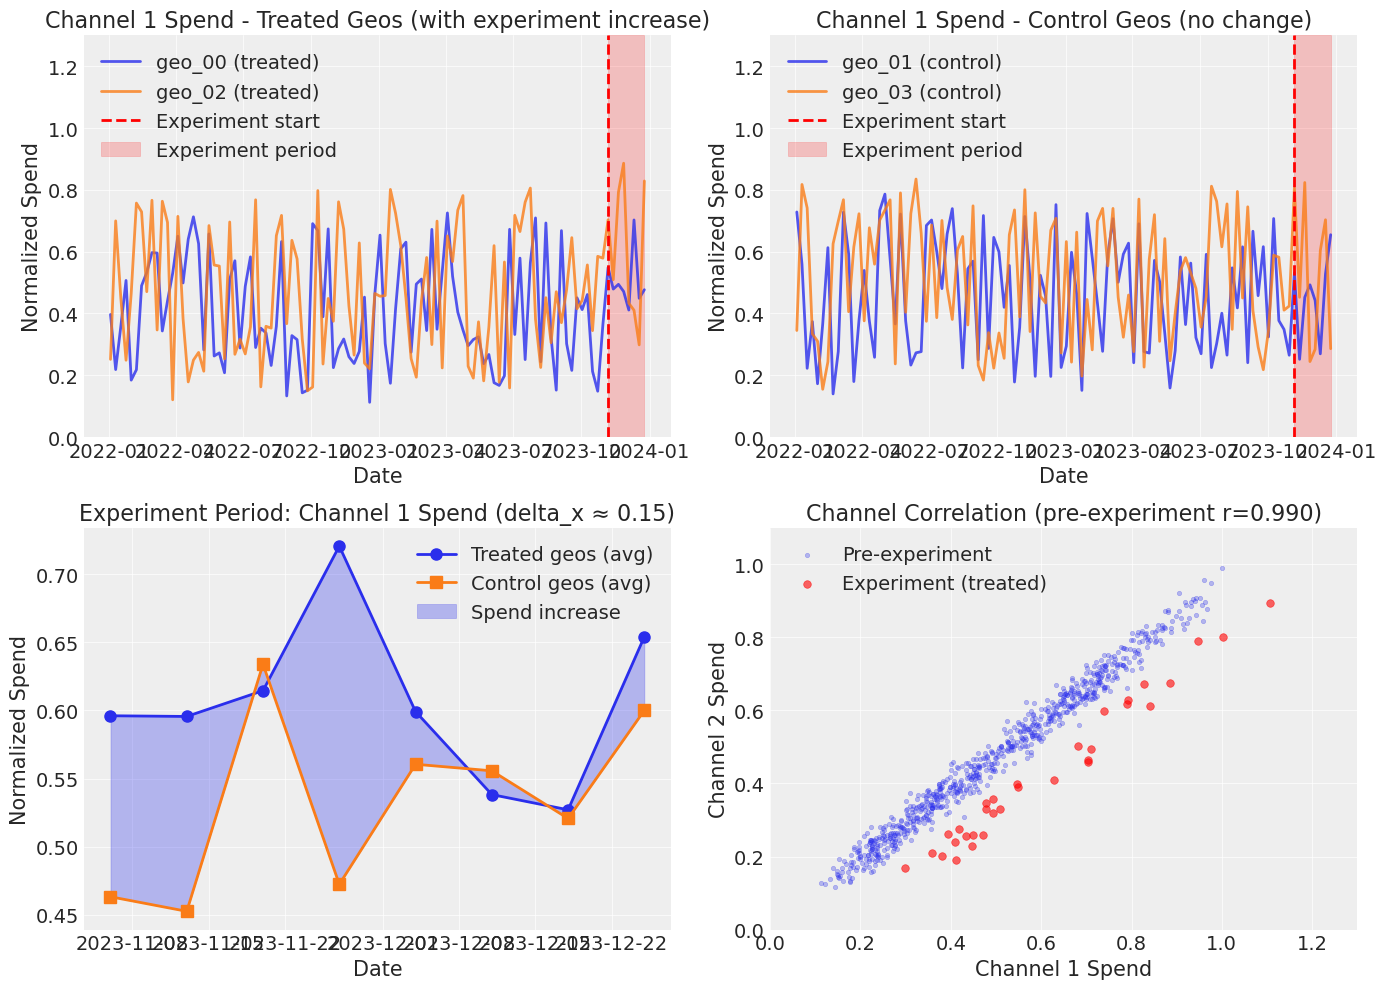

In [5]:
# Visualize spend patterns with experiment highlighted
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Channel 1 spend - Treated geos (showing experiment effect)
ax = axes[0, 0]
for geo in treated_geos[:2]:  # Show 2 treated geos
    geo_data = df[df["geo"] == geo]
    ax.plot(
        geo_data["date"], geo_data["channel_1"], label=f"{geo} (treated)", alpha=0.8
    )
ax.axvline(
    experiment_start_date,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Experiment start",
)
ax.axvspan(
    experiment_start_date,
    experiment_end_date,
    alpha=0.2,
    color="red",
    label="Experiment period",
)
ax.set_title("Channel 1 Spend - Treated Geos (with experiment increase)")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Spend")
ax.legend(loc="upper left")
ax.set_ylim(0, 1.3)

# Plot 2: Channel 1 spend - Control geos (no experiment effect)
ax = axes[0, 1]
for geo in control_geos[:2]:  # Show 2 control geos
    geo_data = df[df["geo"] == geo]
    ax.plot(
        geo_data["date"], geo_data["channel_1"], label=f"{geo} (control)", alpha=0.8
    )
ax.axvline(
    experiment_start_date,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Experiment start",
)
ax.axvspan(
    experiment_start_date,
    experiment_end_date,
    alpha=0.2,
    color="red",
    label="Experiment period",
)
ax.set_title("Channel 1 Spend - Control Geos (no change)")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Spend")
ax.legend(loc="upper left")
ax.set_ylim(0, 1.3)

# Plot 3: Average spend comparison during experiment
ax = axes[1, 0]
# Compute weekly averages for treated vs control during experiment
exp_df = df[df["date"] >= experiment_start_date].copy()
treated_avg = (
    exp_df[exp_df["geo"].isin(treated_geos)].groupby("date")["channel_1"].mean()
)
control_avg = (
    exp_df[exp_df["geo"].isin(control_geos)].groupby("date")["channel_1"].mean()
)

ax.plot(
    treated_avg.index,
    treated_avg.values,
    "o-",
    label="Treated geos (avg)",
    linewidth=2,
    markersize=8,
)
ax.plot(
    control_avg.index,
    control_avg.values,
    "s-",
    label="Control geos (avg)",
    linewidth=2,
    markersize=8,
)
ax.fill_between(
    treated_avg.index,
    control_avg.values,
    treated_avg.values,
    alpha=0.3,
    color="C0",
    label="Spend increase",
)
ax.set_title(f"Experiment Period: Channel 1 Spend (delta_x ≈ {delta_x_experiment})")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Spend")
ax.legend()

# Plot 4: Channel correlation (pre-experiment)
ax = axes[1, 1]
pre_exp_df = df[df["date"] < experiment_start_date]
ax.scatter(
    pre_exp_df["channel_1"],
    pre_exp_df["channel_2"],
    alpha=0.3,
    s=10,
    label="Pre-experiment",
)
exp_treated = df[(df["date"] >= experiment_start_date) & (df["geo"].isin(treated_geos))]
ax.scatter(
    exp_treated["channel_1"],
    exp_treated["channel_2"],
    alpha=0.6,
    s=30,
    color="red",
    label="Experiment (treated)",
)
ax.set_title(f"Channel Correlation (pre-experiment r={corr:.3f})")
ax.set_xlabel("Channel 1 Spend")
ax.set_ylabel("Channel 2 Spend")
ax.set_xlim(0, 1.3)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()

### Define True Parameters with Geo-Level Heterogeneity

A key advantage of geo-level modeling is capturing **regional heterogeneity** in media response. Different markets may have different saturation characteristics due to:
- **Market maturity**: Established markets may saturate faster than emerging ones
- **Competition**: Competitive markets may require more spend to achieve the same effect
- **Demographics**: Different audience compositions respond differently to media

We model this heterogeneity using a **hierarchical structure**:
- Each geo has its own saturation parameters (lam, beta)
- These geo-level parameters are drawn from a common population distribution
- This allows **partial pooling**: information is shared across geos while allowing for regional differences

**True parameter structure** (for normalized [0, 1] spend data):
- **Saturation lam**: Population mean ~8 for channel 1, ~6 for channel 2, with geo-level variation (σ ≈ 1.0)
- **Saturation beta**: Population mean ~0.6 for channel 1, ~0.5 for channel 2, with geo-level variation (σ ≈ 0.08)
- **Adstock alpha**: Shared across geos (0.5 for both channels)

This hierarchical structure is crucial for understanding how lift tests help: **calibrating a subset of geos (treated geos) provides information that propagates to all geos through the shared population-level parameters.**

In [6]:
# Define true parameters for data generation
# These will be used with pm.do to fix the model parameters

# Population-level means for saturation parameters
# Higher lam = saturates faster (half-saturation at ~ln(3)/lam)
true_lam_mu_c1 = 8.0  # Population mean for channel 1
true_lam_mu_c2 = 6.0  # Population mean for channel 2
true_lam_sigma = 1.0  # Geo-level variation in lam

# Beta population parameters
true_beta_mu_c1 = 0.6  # Population mean for channel 1
true_beta_mu_c2 = 0.5  # Population mean for channel 2
true_beta_sigma = 0.08  # Geo-level variation in beta

# Generate geo-specific parameters from hierarchical structure
# Each geo gets its own lam and beta, drawn from population distribution
rng_params = np.random.default_rng(seed + 1)  # Separate seed for reproducibility

true_lam = np.zeros((n_geos, n_channels))
true_beta = np.zeros((n_geos, n_channels))

for g in range(n_geos):
    # Channel 1 parameters for this geo
    true_lam[g, 0] = rng_params.normal(true_lam_mu_c1, true_lam_sigma)
    true_beta[g, 0] = rng_params.normal(true_beta_mu_c1, true_beta_sigma)
    # Channel 2 parameters for this geo
    true_lam[g, 1] = rng_params.normal(true_lam_mu_c2, true_lam_sigma)
    true_beta[g, 1] = rng_params.normal(true_beta_mu_c2, true_beta_sigma)

# Ensure lam is positive and beta is positive (reasonable constraints)
true_lam = np.clip(true_lam, 4.0, 12.0)
true_beta = np.clip(true_beta, 0.3, 0.9)

# Adstock alpha (shared across geos, as carryover is often similar)
true_alpha_c1 = 0.5
true_alpha_c2 = 0.5

# Intercept per geo (base level)
true_intercept = np.array([0.3 + 0.05 * i for i in range(n_geos)])

true_params = {
    "adstock_alpha": np.array([true_alpha_c1, true_alpha_c2]),
    "saturation_lam": true_lam,
    "saturation_beta": true_beta,
    "intercept_contribution": true_intercept,
    "y_sigma": np.full(n_geos, 0.15),  # Noise level per geo
}

# Display summary
print("True parameters (hierarchical structure):")
print(f"  Adstock alpha (shared): {true_params['adstock_alpha']}")
print("\nSaturation lam by geo (channel 1 | channel 2):")
for g, geo in enumerate(geos):
    treated = "(treated)" if geo in treated_geos else "(control)"
    print(f"  {geo} {treated}: {true_lam[g, 0]:.2f} | {true_lam[g, 1]:.2f}")
print(f"\nPopulation means: lam_c1={true_lam_mu_c1}, lam_c2={true_lam_mu_c2}")
print(
    f"Observed geo means: lam_c1={true_lam[:, 0].mean():.2f}, lam_c2={true_lam[:, 1].mean():.2f}"
)
print("\nSaturation beta by geo (channel 1 | channel 2):")
for g, geo in enumerate(geos):
    treated = "(treated)" if geo in treated_geos else "(control)"
    print(f"  {geo} {treated}: {true_beta[g, 0]:.2f} | {true_beta[g, 1]:.2f}")
print(f"\nPopulation means: beta_c1={true_beta_mu_c1}, beta_c2={true_beta_mu_c2}")

True parameters (hierarchical structure):
  Adstock alpha (shared): [0.5 0.5]

Saturation lam by geo (channel 1 | channel 2):
  geo_00 (treated): 6.91 | 6.04
  geo_01 (control): 9.51 | 5.25
  geo_02 (treated): 7.93 | 6.41
  geo_03 (control): 8.08 | 5.01
  geo_04 (treated): 6.42 | 6.55
  geo_05 (control): 8.15 | 5.84
  geo_06 (treated): 7.51 | 7.02
  geo_07 (control): 9.13 | 5.60

Population means: lam_c1=8.0, lam_c2=6.0
Observed geo means: lam_c1=7.96, lam_c2=5.97

Saturation beta by geo (channel 1 | channel 2):
  geo_00 (treated): 0.52 | 0.53
  geo_01 (control): 0.64 | 0.33
  geo_02 (treated): 0.59 | 0.51
  geo_03 (control): 0.66 | 0.50
  geo_04 (treated): 0.65 | 0.61
  geo_05 (control): 0.65 | 0.43
  geo_06 (treated): 0.66 | 0.59
  geo_07 (control): 0.48 | 0.46

Population means: beta_c1=0.6, beta_c2=0.5


### Generate Target Variable Using the Model

Following the national-level notebook, we generate the target variable `y` directly from the model using `pm.do` to fix the true parameters. This ensures **perfect consistency** between data generation and model assumptions.

In [7]:
# Initialize placeholder y
df["y"] = np.ones(len(df))

# Prepare data for model
X = df[["date", "geo", "channel_1", "channel_2"]].copy()
y = df["y"]

print(f"Data shapes: X={X.shape}, y={y.shape}")

Data shapes: X=(832, 4), y=(832,)


In [8]:
# Define HIERARCHICAL priors appropriate for normalized [0,1] inputs
# The hierarchical structure allows information to flow between geos

adstock_priors = {
    # Adstock is shared across geos (dims="channel" only)
    "alpha": Prior("Beta", alpha=2, beta=2, dims="channel"),
}

# Hierarchical saturation priors:
# - Population-level parameters (mu, sigma) are shared across geos
# - Geo-level parameters are drawn from the population distribution
# - This enables partial pooling: lift tests in some geos inform all geos

saturation_priors = {
    # Hierarchical lam: geo-level parameters drawn from population Gamma
    # mu prior: Gamma with mean ~8 (appropriate for normalized inputs)
    # sigma prior: HalfNormal to control geo-level spread
    "lam": Prior(
        "Gamma",
        mu=Prior("Gamma", alpha=4, beta=0.5, dims="channel"),
        sigma=Prior("HalfNormal", sigma=2, dims="channel"),
        dims=("geo", "channel"),
    ),
    # Hierarchical beta: geo-level contributions drawn from population
    # Using LogNormal to ensure positivity with controlled spread
    "beta": Prior(
        "TruncatedNormal",
        mu=Prior("HalfNormal", sigma=1, dims="channel"),
        sigma=Prior("HalfNormal", sigma=0.3, dims="channel"),
        lower=0.01,
        upper=2.0,
        dims=("geo", "channel"),
    ),
}

print("Hierarchical priors defined:")
print("  Adstock alpha: Beta(2, 2) - shared across geos")
print("\n  Saturation lam (hierarchical):")
print("    Population mu: Gamma(4, 0.5) per channel")
print("    Population sigma: HalfNormal(2) per channel")
print("    Geo-level: Gamma(mu, sigma) per geo-channel")
print("\n  Saturation beta (hierarchical):")
print("    Population mu: HalfNormal(1) per channel")
print("    Population sigma: HalfNormal(0.3) per channel")
print("    Geo-level: TruncatedNormal(mu, sigma, 0.01, 2.0) per geo-channel")

Hierarchical priors defined:
  Adstock alpha: Beta(2, 2) - shared across geos

  Saturation lam (hierarchical):
    Population mu: Gamma(4, 0.5) per channel
    Population sigma: HalfNormal(2) per channel
    Geo-level: Gamma(mu, sigma) per geo-channel

  Saturation beta (hierarchical):
    Population mu: HalfNormal(1) per channel
    Population sigma: HalfNormal(0.3) per channel
    Geo-level: TruncatedNormal(mu, sigma, 0.01, 2.0) per geo-channel


#### How Hierarchical Priors Enable Information Flow

The hierarchical prior structure is key to understanding how geo-level lift tests improve the entire model, not just the tested geos.

**The Mechanism:**

1. **Direct calibration of treated geos**: Lift tests in treated geos (geo_00, geo_02, geo_04, geo_06) directly constrain those geos' saturation parameters to match the experimentally observed effect.

2. **Information flows to population parameters**: When the model learns that treated geos have certain lam/beta values, it updates the *population-level* parameters (mu and sigma) that generated them.

3. **Population parameters inform control geos**: The updated population parameters then provide better priors for the *untested* control geos (geo_01, geo_03, geo_05, geo_07), even though they weren't directly calibrated.

**Why This Matters:**

| Geo Type | Without Hierarchical Priors | With Hierarchical Priors |
|----------|----------------------------|--------------------------|
| Treated geos | Directly calibrated | Directly calibrated |
| Control geos | No benefit from lift tests | Indirectly calibrated via population |

This is the essence of **partial pooling**: information from the experiment propagates across all geos through the shared population distribution. The more geos you test, the better the population parameters become, and the more all geos benefit.

In [9]:
# Build a temporary model to generate data
mmm_temp = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_temp.build_model(X, y)
print("Temporary model built for data generation")
print(f"Model coords: {list(mmm_temp.model.coords.keys())}")

Temporary model built for data generation
Model coords: ['date', 'geo', 'channel']


In [10]:
# Generate y from the model with fixed true parameters
# This ensures perfect consistency between data and model assumptions
fixed_model = pm.do(mmm_temp.model, true_params)
y_drawn = pm.draw(fixed_model["y"], random_seed=rng)

# y_drawn has shape (n_dates, n_geos) with dims ("date", "geo")
# Convert to DataFrame format matching our row order
y_xr = xr.DataArray(
    y_drawn,
    dims=["date", "geo"],
    coords={"date": dates, "geo": geos},
)
y_df = y_xr.to_dataframe(name="y").reset_index()

# Merge back to our DataFrame
df = df.drop(columns=["y"]).merge(y_df, on=["date", "geo"])

# Clean up temporary model
del mmm_temp.model

print("Target variable generated from model:")
print(f"  Shape: {y_drawn.shape} (date, geo)")
print(f"  Mean: {df['y'].mean():.3f}")
print(f"  Std: {df['y'].std():.3f}")
print(f"  Range: [{df['y'].min():.3f}, {df['y'].max():.3f}]")

Target variable generated from model:
  Shape: (104, 8) (date, geo)
  Mean: 1.465
  Std: 0.250
  Range: [0.650, 2.192]


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/441902970.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


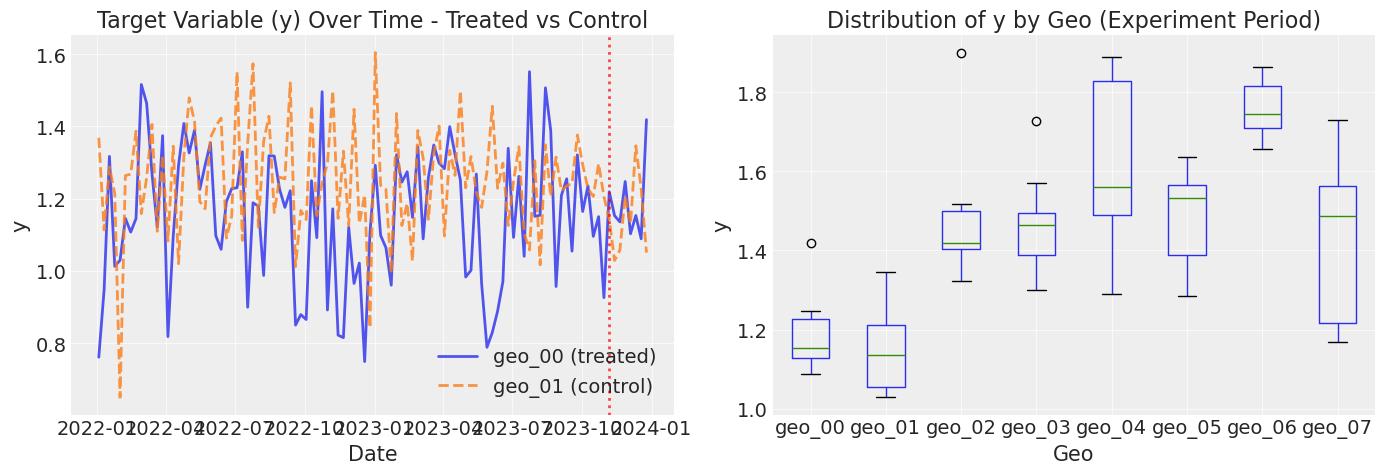

In [11]:
# Visualize generated data - showing experiment effect on outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: y over time comparing treated vs control
ax = axes[0]
# Show one treated and one control geo
for geo, style in [(treated_geos[0], "-"), (control_geos[0], "--")]:
    geo_data = df[df["geo"] == geo]
    label = f"{geo} ({'treated' if geo in treated_geos else 'control'})"
    ax.plot(geo_data["date"], geo_data["y"], style, label=label, alpha=0.8)
ax.axvline(experiment_start_date, color="red", linestyle=":", linewidth=2, alpha=0.7)
ax.set_title("Target Variable (y) Over Time - Treated vs Control")
ax.set_xlabel("Date")
ax.set_ylabel("y")
ax.legend()

# Plot 2: Distribution of y by geo (during experiment)
ax = axes[1]
exp_data = df[df["date"] >= experiment_start_date]
exp_data.boxplot(column="y", by="geo", ax=ax)
ax.set_title("Distribution of y by Geo (Experiment Period)")
ax.set_xlabel("Geo")
ax.set_ylabel("y")
plt.suptitle("")

plt.tight_layout()
plt.show()

## Fit MMM Without Calibration

First, let's fit a standard MMM without lift test calibration to establish a baseline.

In [12]:
# Prepare data
X = df[["date", "geo", "channel_1", "channel_2"]].copy()
y = df["y"]

# Initialize MMM (same structure as data generation)
mmm_uncalibrated = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_uncalibrated.build_model(X, y)
print("Uncalibrated model built")

Uncalibrated model built


In [13]:
# Fit the model using nutpie for faster sampling
fit_kwargs = {
    "tune": 1000,
    "draws": 1000,
    "chains": 4,
    "random_seed": rng,
    "nuts_sampler": "nutpie",
}

idata_uncalibrated = mmm_uncalibrated.fit(X, y, **fit_kwargs)
print("\nUncalibrated model fitted")

Error updating progress display: <ContextVar name='parent_header' at 0x12927ae80>


Output()


Uncalibrated model fitted


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/2089061387.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


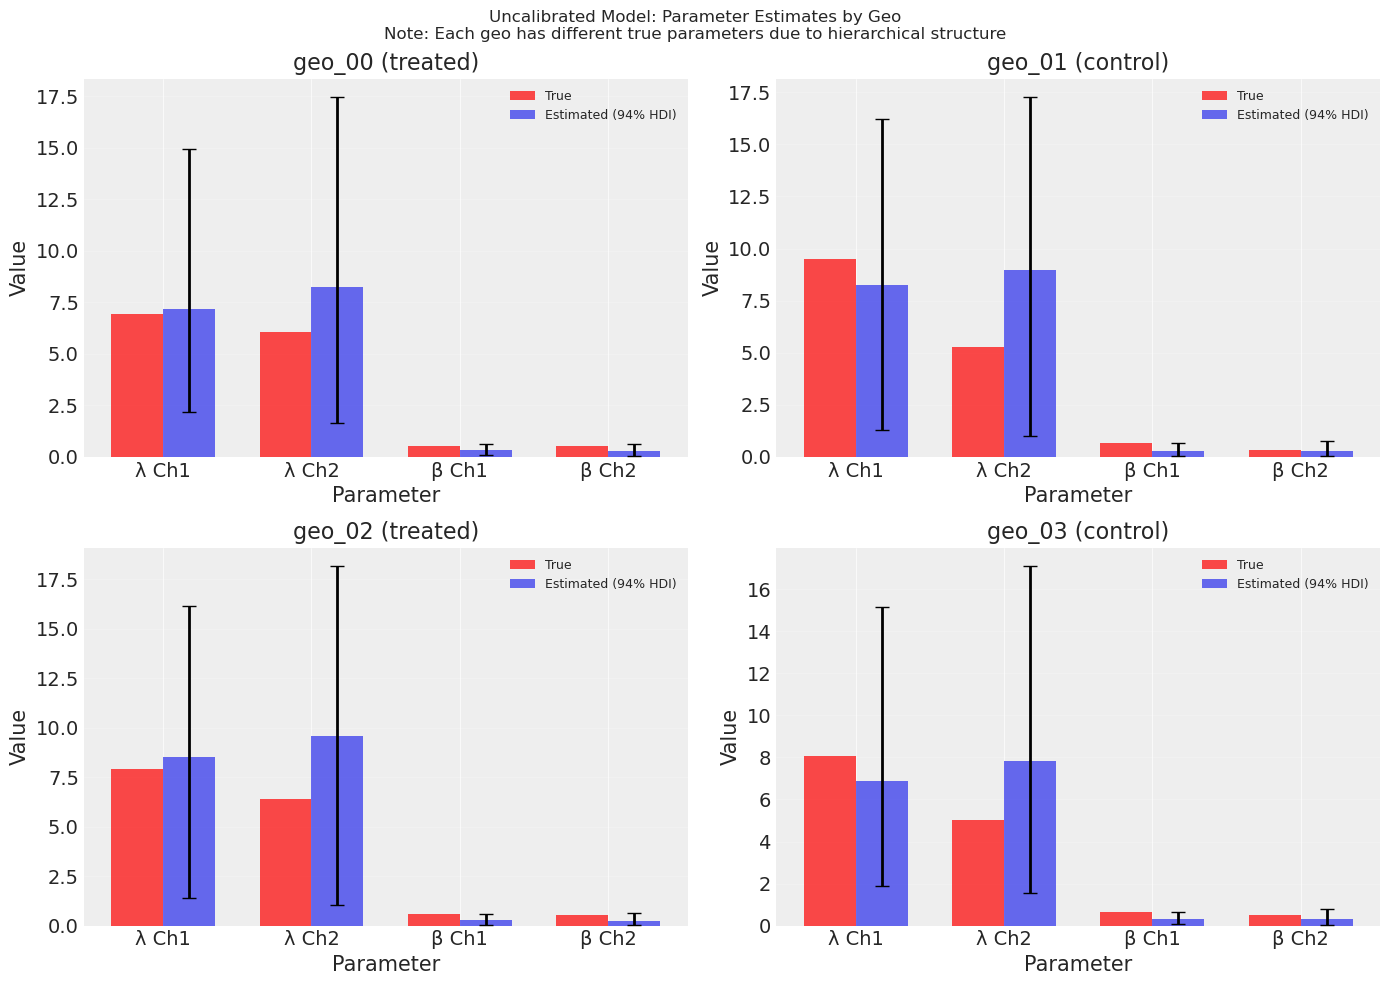


Note: The uncalibrated model struggles to recover geo-specific parameters
because highly correlated channels make it hard to identify the saturation curves.


In [14]:
# Visualize parameter estimates vs true values for multiple geos
# This shows how the uncalibrated model estimates geo-specific parameters
posterior = idata_uncalibrated.posterior

# Show a sample of geos (2 treated, 2 control)
sample_geos = [geos[0], geos[1], geos[2], geos[3]]  # geo_00, geo_01, geo_02, geo_03

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax_idx, geo in enumerate(sample_geos):
    geo_idx = geos.index(geo)
    is_treated = geo in treated_geos
    geo_label = "(treated)" if is_treated else "(control)"

    ax = axes[ax_idx // 2, ax_idx % 2]

    # Parameter names for this geo
    param_names = ["λ Ch1", "λ Ch2", "β Ch1", "β Ch2"]

    # True values for THIS geo
    true_values = [
        true_lam[geo_idx, 0],
        true_lam[geo_idx, 1],
        true_beta[geo_idx, 0],
        true_beta[geo_idx, 1],
    ]

    # Extract posterior samples for this geo
    lam_c1 = posterior["saturation_lam"][:, :, geo_idx, 0].values.flatten()
    lam_c2 = posterior["saturation_lam"][:, :, geo_idx, 1].values.flatten()
    beta_c1 = posterior["saturation_beta"][:, :, geo_idx, 0].values.flatten()
    beta_c2 = posterior["saturation_beta"][:, :, geo_idx, 1].values.flatten()

    samples = [lam_c1, lam_c2, beta_c1, beta_c2]

    # Compute means and HDI
    est_means = [np.mean(s) for s in samples]
    hdi_low = [np.percentile(s, 3) for s in samples]
    hdi_high = [np.percentile(s, 97) for s in samples]

    x_pos = np.arange(len(param_names))
    bar_width = 0.35

    # True values as bars
    ax.bar(
        x_pos - bar_width / 2,
        true_values,
        bar_width,
        label="True",
        color="red",
        alpha=0.7,
    )

    # Estimated values with error bars
    errors = [
        [est_means[i] - hdi_low[i] for i in range(len(est_means))],
        [hdi_high[i] - est_means[i] for i in range(len(est_means))],
    ]
    ax.bar(
        x_pos + bar_width / 2,
        est_means,
        bar_width,
        label="Estimated (94% HDI)",
        color="C0",
        alpha=0.7,
        yerr=errors,
        capsize=5,
    )

    ax.set_xlabel("Parameter")
    ax.set_ylabel("Value")
    ax.set_title(f"{geo} {geo_label}")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(param_names)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle(
    "Uncalibrated Model: Parameter Estimates by Geo\n"
    "Note: Each geo has different true parameters due to hierarchical structure",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print("\nNote: The uncalibrated model struggles to recover geo-specific parameters")
print(
    "because highly correlated channels make it hard to identify the saturation curves."
)

## Create Lift Test Measurements

Recall that during data generation, we simulated a geo-level lift test on **channel 1** in 4 treated geos. The experiment is visible in the data: treated geos have increased channel 1 spend during the final 8 weeks.

Now we extract the lift test measurements that would come from analyzing this experiment (e.g., via CausalPy synthetic control). For each treated geo, we calculate:
- `x`: baseline (normalized) spend *before* the experiment
- `delta_x`: the incremental spend change applied during the experiment
- `delta_y`: the causal lift, computed from the true saturation curve (simulating what CausalPy would estimate)

**Key principle**: The lift test uses the **same saturation function** that the model uses, ensuring consistency.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/1190894313.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


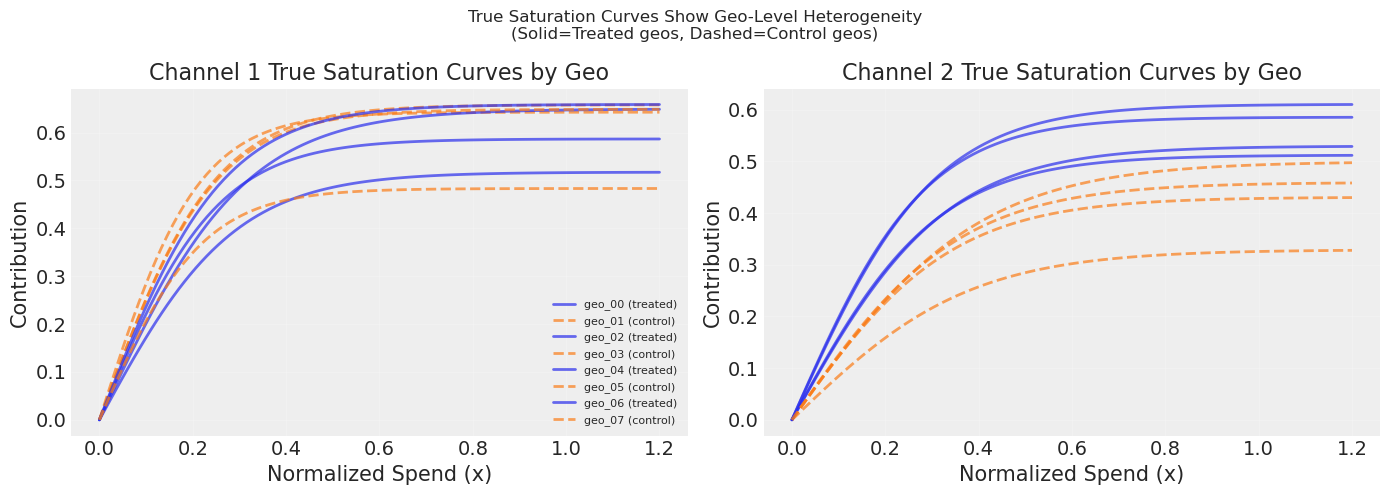


Note: Each geo has its own saturation curve due to hierarchical structure.
Treated geos will be directly calibrated; control geos benefit through partial pooling.


In [15]:
# Define the saturation function matching the model
def saturation_function(x, lam, beta):
    """Compute saturation contribution (same as model uses)."""
    return (beta * logistic_saturation(x, lam)).eval()


# Create geo-specific curve functions for channel 1 (the test channel)
def get_geo_curve_fn(geo_idx, channel_idx=0):
    """Get saturation curve function for a specific geo and channel."""
    return partial(
        saturation_function,
        lam=true_lam[geo_idx, channel_idx],
        beta=true_beta[geo_idx, channel_idx],
    )


# Visualize the true saturation curves for ALL geos (showing heterogeneity)
xx = np.linspace(0, 1.2, 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Channel 1 - the test channel
ax = axes[0]
for g, geo in enumerate(geos):
    curve = saturation_function(xx, true_lam[g, 0], true_beta[g, 0])
    color = "C0" if geo in treated_geos else "C1"
    linestyle = "-" if geo in treated_geos else "--"
    label = f"{geo} (treated)" if geo in treated_geos else f"{geo} (control)"
    ax.plot(xx, curve, color=color, linestyle=linestyle, alpha=0.7, label=label)

ax.set_xlabel("Normalized Spend (x)")
ax.set_ylabel("Contribution")
ax.set_title("Channel 1 True Saturation Curves by Geo")
ax.legend(loc="lower right", fontsize=8)
ax.grid(True, alpha=0.3)

# Channel 2 - not tested
ax = axes[1]
for g, geo in enumerate(geos):
    curve = saturation_function(xx, true_lam[g, 1], true_beta[g, 1])
    color = "C0" if geo in treated_geos else "C1"
    linestyle = "-" if geo in treated_geos else "--"
    ax.plot(xx, curve, color=color, linestyle=linestyle, alpha=0.7)

ax.set_xlabel("Normalized Spend (x)")
ax.set_ylabel("Contribution")
ax.set_title("Channel 2 True Saturation Curves by Geo")
ax.grid(True, alpha=0.3)

plt.suptitle(
    "True Saturation Curves Show Geo-Level Heterogeneity\n"
    "(Solid=Treated geos, Dashed=Control geos)",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print("\nNote: Each geo has its own saturation curve due to hierarchical structure.")
print(
    "Treated geos will be directly calibrated; control geos benefit through partial pooling."
)

In [16]:
# Lift test setup (already defined during data generation)
# Recap the experiment parameters:
print("Lift Test Setup (from data generation):")
print(f"  Test channel: {test_channel}")
print(
    f"  Experiment period: {experiment_start_date.date()} to {experiment_end_date.date()}"
)
print(f"  Treated geos: {treated_geos}")
print(f"  Control geos: {control_geos}")
print(f"  Spend increase (delta_x): {delta_x_experiment}")

Lift Test Setup (from data generation):
  Test channel: channel_1
  Experiment period: 2023-11-06 to 2023-12-25
  Treated geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']
  Control geos: ['geo_01', 'geo_03', 'geo_05', 'geo_07']
  Spend increase (delta_x): 0.15


In [17]:
def create_lift_test(
    geo: str, geo_idx: int, x: float, delta_x: float, sigma: float
) -> dict:
    """
    Create a lift test measurement using the geo-specific saturation curve.

    This directly uses the saturation function with geo-specific parameters,
    ensuring consistency with what add_lift_test_measurements() expects.

    In practice, delta_y would come from a synthetic control analysis
    (e.g., CausalPy). Here we compute it from the known true curve for that geo.
    """
    # Use geo-specific parameters
    geo_curve_fn = get_geo_curve_fn(geo_idx, channel_idx=0)
    delta_y = geo_curve_fn(x + delta_x) - geo_curve_fn(x)

    return {
        "channel": test_channel,
        "geo": geo,
        "x": x,
        "delta_x": delta_x,
        "delta_y": float(delta_y),
        "sigma": sigma,
    }


# Create lift tests based on the actual experiment in the data
# For each treated geo:
#   - x = baseline spend (pre-experiment average for that geo)
#   - delta_x = the actual spend increase applied during the experiment
#   - delta_y = computed from geo-specific true saturation curve (simulating CausalPy)
lift_test_results = []

for geo in treated_geos:
    geo_idx = geos.index(geo)
    geo_data = df[df["geo"] == geo]

    # Baseline spend: average channel_1 spend BEFORE the experiment
    pre_experiment_data = geo_data[geo_data["date"] < experiment_start_date]
    x_baseline = pre_experiment_data[test_channel].mean()

    # The spend increase is what we applied during data generation
    delta_x = delta_x_experiment

    # Measurement uncertainty (would come from synthetic control analysis)
    sigma = 0.02

    lift_test = create_lift_test(geo, geo_idx, x_baseline, delta_x, sigma)
    lift_test_results.append(lift_test)

    # Verify: actual spend during experiment should be close to x + delta_x
    during_experiment_data = geo_data[geo_data["date"] >= experiment_start_date]
    actual_spend = during_experiment_data[test_channel].mean()

    # Show geo-specific parameters
    geo_lam = true_lam[geo_idx, 0]
    geo_beta = true_beta[geo_idx, 0]

    print(
        f"{geo}: x={x_baseline:.3f}, delta_x={delta_x:.2f}, delta_y={lift_test['delta_y']:.4f} "
        f"(lam={geo_lam:.2f}, beta={geo_beta:.2f})"
    )

df_lift_test = pd.DataFrame(lift_test_results)
print("\nLift Test DataFrame (geo-specific measurements):")
print("Note: Each delta_y is computed from that geo's true saturation curve.")
df_lift_test

geo_00: x=0.403, delta_x=0.15, delta_y=0.0380 (lam=6.91, beta=0.52)
geo_02: x=0.463, delta_x=0.15, delta_y=0.0201 (lam=7.93, beta=0.59)
geo_04: x=0.497, delta_x=0.15, delta_y=0.0313 (lam=6.42, beta=0.65)
geo_06: x=0.589, delta_x=0.15, delta_y=0.0105 (lam=7.51, beta=0.66)

Lift Test DataFrame (geo-specific measurements):
Note: Each delta_y is computed from that geo's true saturation curve.


,channel,geo,x,delta_x,delta_y,sigma
0,channel_1,geo_00,0.403014,0.15,0.037961,0.02
1,channel_1,geo_02,0.463227,0.15,0.020084,0.02
2,channel_1,geo_04,0.497020,0.15,0.031283,0.02
3,channel_1,geo_06,0.588885,0.15,0.010507,0.02


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/3887993510.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


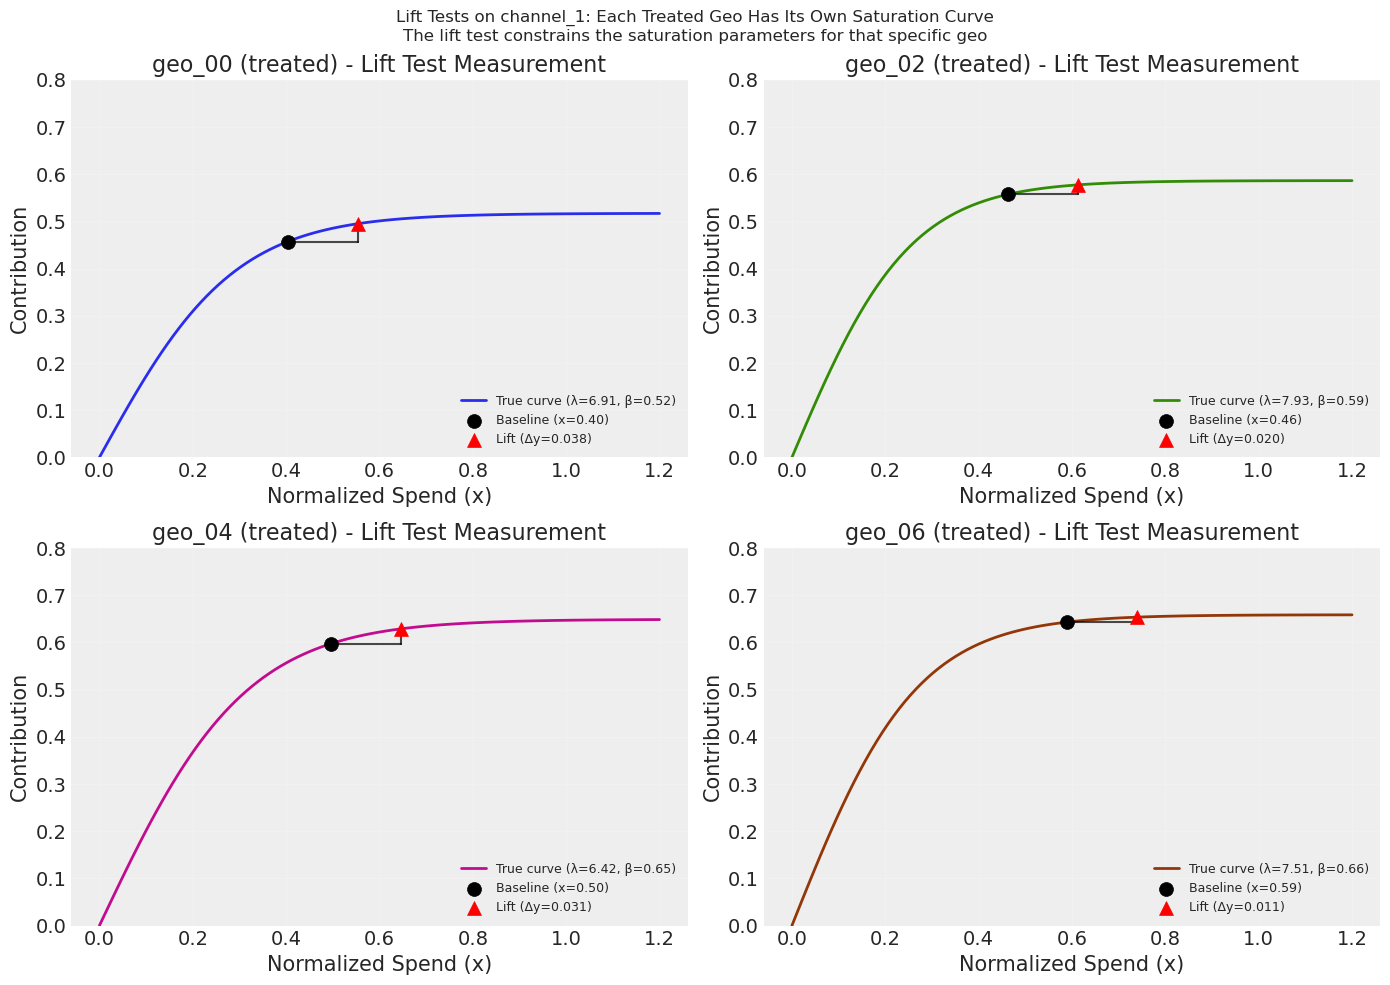


Key insight: Each geo's lift test measures a point on THAT GEO's saturation curve.
Through hierarchical priors, these measurements also inform the population distribution,
which in turn provides better priors for the control geos that weren't tested.


In [18]:
# Visualize lift tests on geo-specific saturation curves
# Each treated geo has its own curve, so we show one subplot per geo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ["C0", "C2", "C3", "C4"]  # Different color per geo

for i, (_idx, row) in enumerate(df_lift_test.iterrows()):
    ax = axes[i]
    geo = row["geo"]
    geo_idx = geos.index(geo)

    # Get geo-specific curve
    geo_curve_fn = get_geo_curve_fn(geo_idx, channel_idx=0)
    geo_curve = geo_curve_fn(xx)
    geo_lam = true_lam[geo_idx, 0]
    geo_beta = true_beta[geo_idx, 0]

    # Plot true saturation curve for this geo
    ax.plot(
        xx,
        geo_curve,
        "-",
        color=colors[i],
        linewidth=2,
        label=f"True curve (λ={geo_lam:.2f}, β={geo_beta:.2f})",
    )

    # Plot lift test triangle
    x = row["x"]
    delta_x = row["delta_x"]
    delta_y = row["delta_y"]
    y_base = geo_curve_fn(x)

    # Draw triangle showing lift
    ax.plot([x, x + delta_x], [y_base, y_base], "k-", linewidth=1.5, alpha=0.7)
    ax.plot(
        [x + delta_x, x + delta_x],
        [y_base, y_base + delta_y],
        "k-",
        linewidth=1.5,
        alpha=0.7,
    )
    ax.scatter(
        [x], [y_base], color="black", s=100, zorder=5, label=f"Baseline (x={x:.2f})"
    )
    ax.scatter(
        [x + delta_x],
        [y_base + delta_y],
        color="red",
        s=100,
        zorder=5,
        marker="^",
        label=f"Lift (Δy={delta_y:.3f})",
    )

    ax.set_xlabel("Normalized Spend (x)")
    ax.set_ylabel("Contribution")
    ax.set_title(f"{geo} (treated) - Lift Test Measurement")
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.8)

plt.suptitle(
    f"Lift Tests on {test_channel}: Each Treated Geo Has Its Own Saturation Curve\n"
    "The lift test constrains the saturation parameters for that specific geo",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print(
    "\nKey insight: Each geo's lift test measures a point on THAT GEO's saturation curve."
)
print(
    "Through hierarchical priors, these measurements also inform the population distribution,"
)
print("which in turn provides better priors for the control geos that weren't tested.")

## Fit MMM With Lift Test Calibration

Now we fit a new MMM and add the lift test measurements to calibrate it.

In [19]:
# Initialize calibrated MMM with same priors
mmm_calibrated = MMM(
    date_column="date",
    channel_columns=channels,
    adstock=GeometricAdstock(priors=adstock_priors, l_max=8),
    saturation=LogisticSaturation(priors=saturation_priors),
    dims=("geo",),
)

mmm_calibrated.build_model(X, y)
print("Calibrated model built")

Calibrated model built


In [20]:
# Add lift test measurements
mmm_calibrated.add_lift_test_measurements(df_lift_test)
print(f"Added {len(df_lift_test)} lift test measurements")
print(f"Lift tests cover geos: {df_lift_test['geo'].unique().tolist()}")

Added 4 lift test measurements
Lift tests cover geos: ['geo_00', 'geo_02', 'geo_04', 'geo_06']


In [21]:
# Fit the calibrated model
idata_calibrated = mmm_calibrated.fit(X, y, **fit_kwargs)
print("\nCalibrated model fitted")

Error updating progress display: <ContextVar name='parent_header' at 0x12927ae80>


Output()


Calibrated model fitted


## Compare Results: Calibrated vs Uncalibrated

Let's compare parameter recovery between the two models.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/3659355100.py:166: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


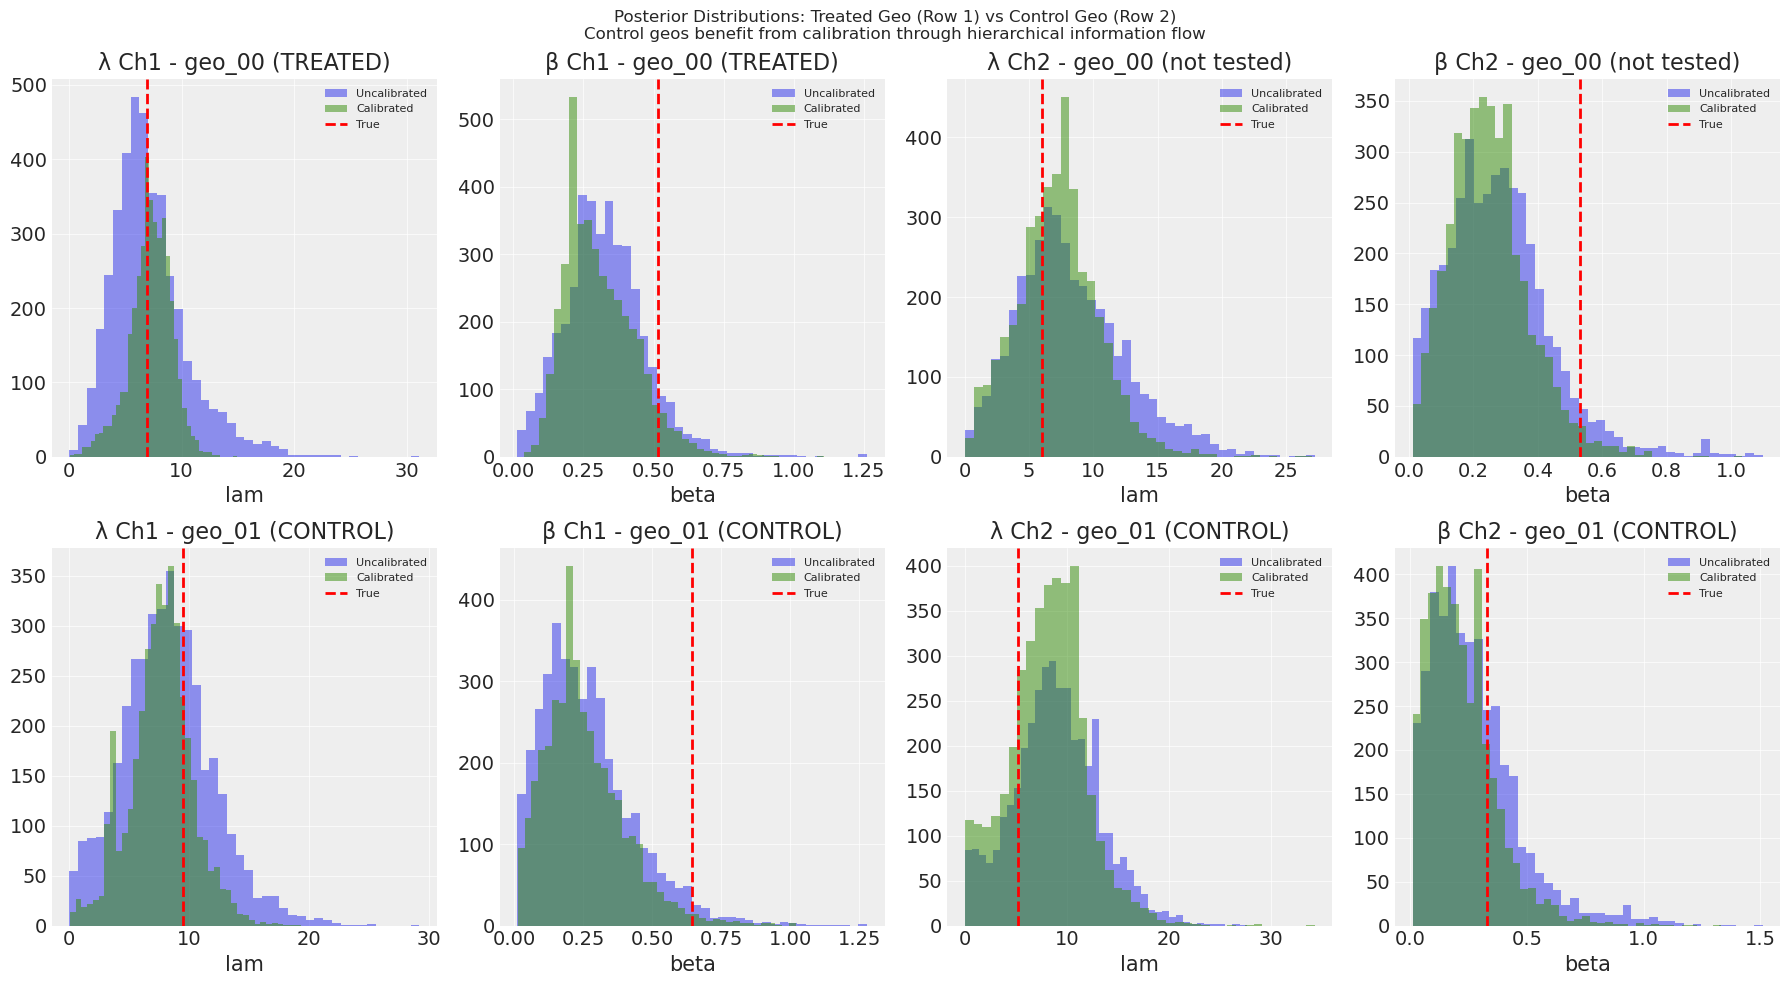


Key observation: Even the CONTROL geo shows improvement from calibration!
This is the power of hierarchical priors: lift tests in treated geos
update the population distribution, which improves all geo estimates.


In [22]:
# Extract posteriors for comparison
posterior_uncal = idata_uncalibrated.posterior
posterior_cal = idata_calibrated.posterior

# Compare treated geo (directly calibrated) vs control geo (indirectly calibrated)
# This demonstrates the hierarchical information flow

treated_geo_idx = 0  # geo_00 (treated)
control_geo_idx = 1  # geo_01 (control)
treated_geo = geos[treated_geo_idx]
control_geo = geos[control_geo_idx]

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Row 1: Treated geo (directly calibrated)
# Saturation lam - Channel 1 (TESTED)
ax = axes[0, 0]
samples_uncal = posterior_uncal["saturation_lam"][
    :, :, treated_geo_idx, 0
].values.flatten()
samples_cal = posterior_cal["saturation_lam"][:, :, treated_geo_idx, 0].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_lam[treated_geo_idx, 0], color="red", linestyle="--", linewidth=2, label="True"
)
ax.set_title(f"λ Ch1 - {treated_geo} (TREATED)")
ax.set_xlabel("lam")
ax.legend(fontsize=8)

# Saturation beta - Channel 1 (TESTED)
ax = axes[0, 1]
samples_uncal = posterior_uncal["saturation_beta"][
    :, :, treated_geo_idx, 0
].values.flatten()
samples_cal = posterior_cal["saturation_beta"][
    :, :, treated_geo_idx, 0
].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_beta[treated_geo_idx, 0],
    color="red",
    linestyle="--",
    linewidth=2,
    label="True",
)
ax.set_title(f"β Ch1 - {treated_geo} (TREATED)")
ax.set_xlabel("beta")
ax.legend(fontsize=8)

# Saturation lam - Channel 2 (NOT tested)
ax = axes[0, 2]
samples_uncal = posterior_uncal["saturation_lam"][
    :, :, treated_geo_idx, 1
].values.flatten()
samples_cal = posterior_cal["saturation_lam"][:, :, treated_geo_idx, 1].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_lam[treated_geo_idx, 1], color="red", linestyle="--", linewidth=2, label="True"
)
ax.set_title(f"λ Ch2 - {treated_geo} (not tested)")
ax.set_xlabel("lam")
ax.legend(fontsize=8)

# Saturation beta - Channel 2 (NOT tested)
ax = axes[0, 3]
samples_uncal = posterior_uncal["saturation_beta"][
    :, :, treated_geo_idx, 1
].values.flatten()
samples_cal = posterior_cal["saturation_beta"][
    :, :, treated_geo_idx, 1
].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_beta[treated_geo_idx, 1],
    color="red",
    linestyle="--",
    linewidth=2,
    label="True",
)
ax.set_title(f"β Ch2 - {treated_geo} (not tested)")
ax.set_xlabel("beta")
ax.legend(fontsize=8)

# Row 2: Control geo (indirectly calibrated through hierarchical structure)
# Saturation lam - Channel 1
ax = axes[1, 0]
samples_uncal = posterior_uncal["saturation_lam"][
    :, :, control_geo_idx, 0
].values.flatten()
samples_cal = posterior_cal["saturation_lam"][:, :, control_geo_idx, 0].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_lam[control_geo_idx, 0], color="red", linestyle="--", linewidth=2, label="True"
)
ax.set_title(f"λ Ch1 - {control_geo} (CONTROL)")
ax.set_xlabel("lam")
ax.legend(fontsize=8)

# Saturation beta - Channel 1
ax = axes[1, 1]
samples_uncal = posterior_uncal["saturation_beta"][
    :, :, control_geo_idx, 0
].values.flatten()
samples_cal = posterior_cal["saturation_beta"][
    :, :, control_geo_idx, 0
].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_beta[control_geo_idx, 0],
    color="red",
    linestyle="--",
    linewidth=2,
    label="True",
)
ax.set_title(f"β Ch1 - {control_geo} (CONTROL)")
ax.set_xlabel("beta")
ax.legend(fontsize=8)

# Saturation lam - Channel 2
ax = axes[1, 2]
samples_uncal = posterior_uncal["saturation_lam"][
    :, :, control_geo_idx, 1
].values.flatten()
samples_cal = posterior_cal["saturation_lam"][:, :, control_geo_idx, 1].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_lam[control_geo_idx, 1], color="red", linestyle="--", linewidth=2, label="True"
)
ax.set_title(f"λ Ch2 - {control_geo} (CONTROL)")
ax.set_xlabel("lam")
ax.legend(fontsize=8)

# Saturation beta - Channel 2
ax = axes[1, 3]
samples_uncal = posterior_uncal["saturation_beta"][
    :, :, control_geo_idx, 1
].values.flatten()
samples_cal = posterior_cal["saturation_beta"][
    :, :, control_geo_idx, 1
].values.flatten()
ax.hist(samples_uncal, bins=40, alpha=0.5, label="Uncalibrated", color="C0")
ax.hist(samples_cal, bins=40, alpha=0.5, label="Calibrated", color="C2")
ax.axvline(
    true_beta[control_geo_idx, 1],
    color="red",
    linestyle="--",
    linewidth=2,
    label="True",
)
ax.set_title(f"β Ch2 - {control_geo} (CONTROL)")
ax.set_xlabel("beta")
ax.legend(fontsize=8)

plt.suptitle(
    "Posterior Distributions: Treated Geo (Row 1) vs Control Geo (Row 2)\n"
    "Control geos benefit from calibration through hierarchical information flow",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print("\nKey observation: Even the CONTROL geo shows improvement from calibration!")
print("This is the power of hierarchical priors: lift tests in treated geos")
print("update the population distribution, which improves all geo estimates.")

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/1458686309.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


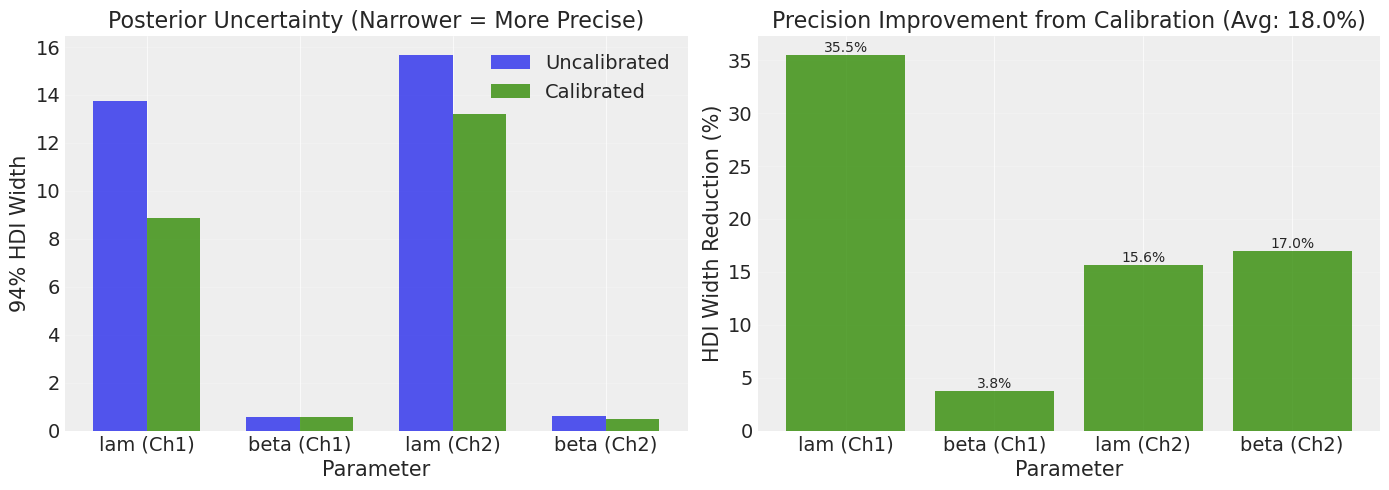

In [23]:
# Visualize HDI width comparison (narrower = better precision)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

params_to_check = [
    ("saturation_lam", 0, "lam (Ch1)"),
    ("saturation_beta", 0, "beta (Ch1)"),
    ("saturation_lam", 1, "lam (Ch2)"),
    ("saturation_beta", 1, "beta (Ch2)"),
]

hdi_widths_uncal = []
hdi_widths_cal = []
improvements = []
param_labels = []

for param_name, ch_idx, display_name in params_to_check:
    # Average across geos
    samples_uncal = posterior_uncal[param_name][:, :, :, ch_idx].values.flatten()
    samples_cal = posterior_cal[param_name][:, :, :, ch_idx].values.flatten()

    hdi_uncal = az.hdi(samples_uncal, hdi_prob=0.94)
    hdi_cal = az.hdi(samples_cal, hdi_prob=0.94)

    width_uncal = hdi_uncal[1] - hdi_uncal[0]
    width_cal = hdi_cal[1] - hdi_cal[0]
    improvement = (width_uncal - width_cal) / width_uncal * 100

    hdi_widths_uncal.append(width_uncal)
    hdi_widths_cal.append(width_cal)
    improvements.append(improvement)
    param_labels.append(display_name)

# Plot HDI widths
x_pos = np.arange(len(param_labels))
bar_width = 0.35

ax = axes[0]
ax.bar(
    x_pos - bar_width / 2,
    hdi_widths_uncal,
    bar_width,
    label="Uncalibrated",
    color="C0",
    alpha=0.8,
)
ax.bar(
    x_pos + bar_width / 2,
    hdi_widths_cal,
    bar_width,
    label="Calibrated",
    color="C2",
    alpha=0.8,
)
ax.set_xlabel("Parameter")
ax.set_ylabel("94% HDI Width")
ax.set_title("Posterior Uncertainty (Narrower = More Precise)")
ax.set_xticks(x_pos)
ax.set_xticklabels(param_labels)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Plot improvement percentage
ax = axes[1]
colors = ["C2" if imp > 0 else "C3" for imp in improvements]
ax.bar(x_pos, improvements, color=colors, alpha=0.8)
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Parameter")
ax.set_ylabel("HDI Width Reduction (%)")
avg_improvement = np.mean(improvements)
ax.set_title(f"Precision Improvement from Calibration (Avg: {avg_improvement:.1f}%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(param_labels)
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for i, imp in enumerate(improvements):
    va = "bottom" if imp >= 0 else "top"
    ax.text(i, imp, f"{imp:.1f}%", ha="center", va=va, fontsize=10)

plt.tight_layout()
plt.show()

### Saturation Curve Recovery

A key benefit of lift test calibration is better recovery of the saturation curves. Let's compare the true curves with the inferred curves from both models.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/655277481.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


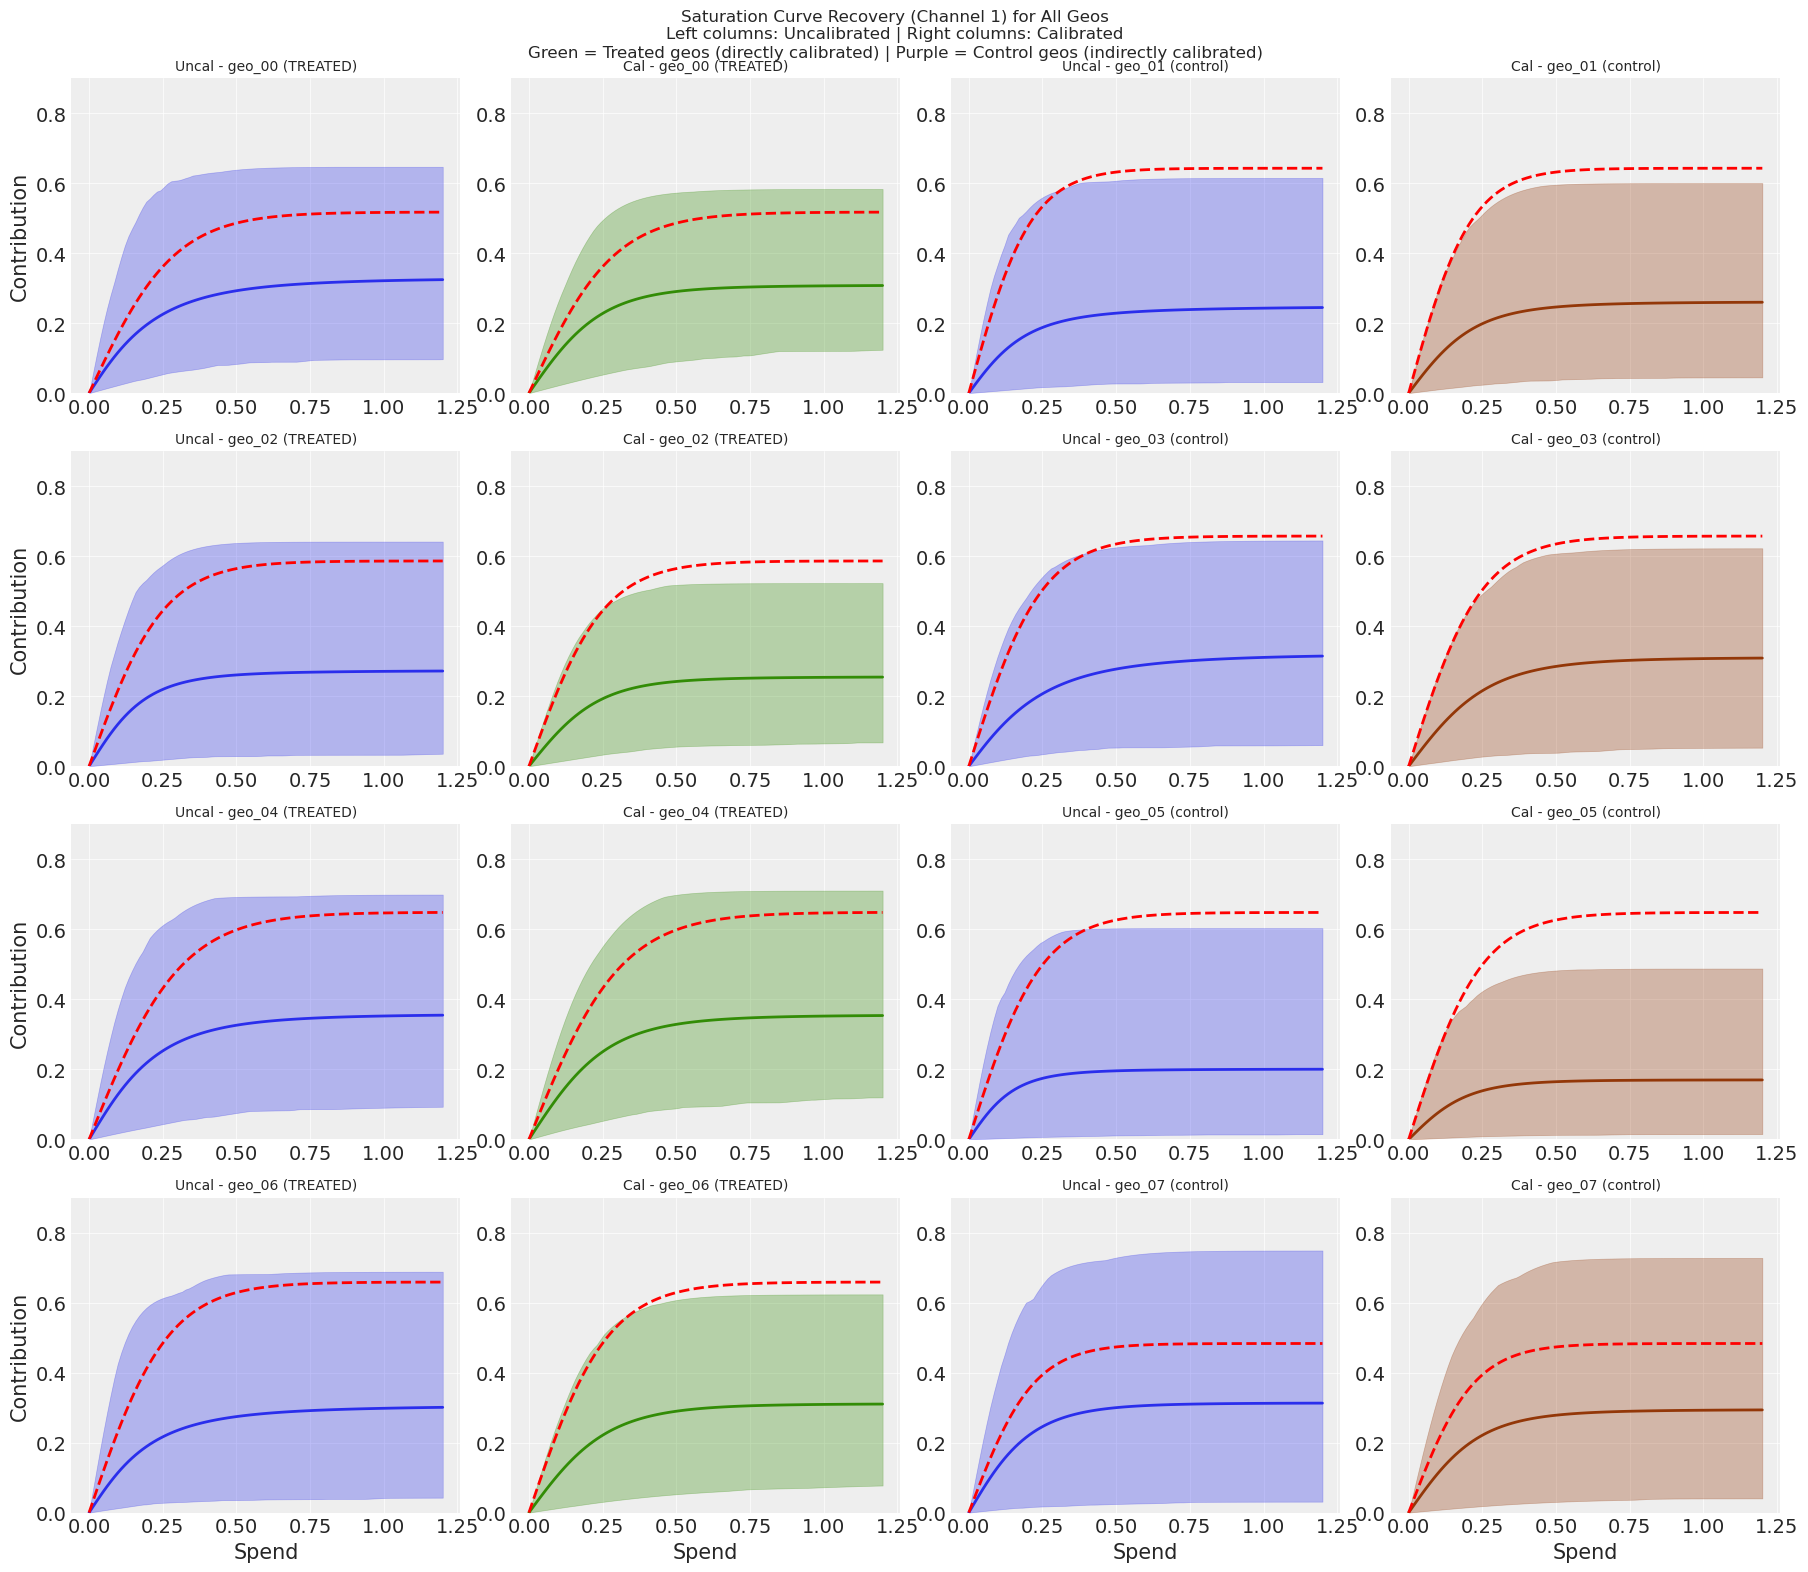


Key observations:
1. TREATED geos (green): Calibration dramatically tightens the HDI bands
2. CONTROL geos (purple): Also show improvement through hierarchical information flow
3. Both groups: Posterior means are closer to true curves after calibration


In [24]:
# Plot saturation curve recovery for ALL geos
# This shows how calibration helps both treated and control geos

x_plot = np.linspace(0, 1.2, 100)


def compute_curve_hdi(lam_samples, beta_samples, x_vals, hdi_prob=0.94):
    """Compute HDI bands for saturation curves."""
    n_samples = min(len(lam_samples), 500)  # Limit for speed
    indices = np.random.choice(len(lam_samples), n_samples, replace=False)
    curves = np.zeros((n_samples, len(x_vals)))
    for i, idx in enumerate(indices):
        curves[i, :] = (
            beta_samples[idx]
            * (1 - np.exp(-lam_samples[idx] * x_vals))
            / (1 + np.exp(-lam_samples[idx] * x_vals))
        )
    mean_curve = np.mean(curves, axis=0)
    lower = np.percentile(curves, (1 - hdi_prob) / 2 * 100, axis=0)
    upper = np.percentile(curves, (1 + hdi_prob) / 2 * 100, axis=0)
    return mean_curve, lower, upper


# Create a grid: rows = geos, columns = [uncalibrated channel 1, calibrated channel 1]
# Focus on channel 1 (the tested channel) for clarity
fig, axes = plt.subplots(4, 4, figsize=(18, 16))

for row, geo in enumerate(geos):
    geo_idx = geos.index(geo)
    is_treated = geo in treated_geos
    geo_label = "(TREATED)" if is_treated else "(control)"

    # Get true curve for this geo
    true_lam_geo = true_params["saturation_lam"][geo_idx, 0]
    true_beta_geo = true_params["saturation_beta"][geo_idx, 0]
    true_curve = (
        true_beta_geo
        * (1 - np.exp(-true_lam_geo * x_plot))
        / (1 + np.exp(-true_lam_geo * x_plot))
    )

    # Uncalibrated model
    ax = axes[row // 2, (row % 2) * 2]
    lam_samples = posterior_uncal["saturation_lam"][:, :, geo_idx, 0].values.flatten()
    beta_samples = posterior_uncal["saturation_beta"][:, :, geo_idx, 0].values.flatten()
    mean_uncal, lower_uncal, upper_uncal = compute_curve_hdi(
        lam_samples, beta_samples, x_plot
    )

    ax.fill_between(x_plot, lower_uncal, upper_uncal, alpha=0.3, color="C0")
    ax.plot(x_plot, mean_uncal, color="C0", linewidth=2, label="Posterior mean")
    ax.plot(x_plot, true_curve, "r--", linewidth=2, label="True curve")
    ax.set_title(f"Uncal - {geo} {geo_label}", fontsize=10)
    ax.set_ylim(0, 0.9)
    if row % 2 == 0:
        ax.set_ylabel("Contribution")
    if row >= 6:
        ax.set_xlabel("Spend")

    # Calibrated model
    ax = axes[row // 2, (row % 2) * 2 + 1]
    lam_samples = posterior_cal["saturation_lam"][:, :, geo_idx, 0].values.flatten()
    beta_samples = posterior_cal["saturation_beta"][:, :, geo_idx, 0].values.flatten()
    mean_cal, lower_cal, upper_cal = compute_curve_hdi(
        lam_samples, beta_samples, x_plot
    )

    color = "C2" if is_treated else "C4"  # Different color for control
    ax.fill_between(x_plot, lower_cal, upper_cal, alpha=0.3, color=color)
    ax.plot(x_plot, mean_cal, color=color, linewidth=2, label="Posterior mean")
    ax.plot(x_plot, true_curve, "r--", linewidth=2, label="True curve")
    ax.set_title(f"Cal - {geo} {geo_label}", fontsize=10)
    ax.set_ylim(0, 0.9)
    if row >= 6:
        ax.set_xlabel("Spend")

plt.suptitle(
    "Saturation Curve Recovery (Channel 1) for All Geos\n"
    "Left columns: Uncalibrated | Right columns: Calibrated\n"
    "Green = Treated geos (directly calibrated) | Purple = Control geos (indirectly calibrated)",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("1. TREATED geos (green): Calibration dramatically tightens the HDI bands")
print(
    "2. CONTROL geos (purple): Also show improvement through hierarchical information flow"
)
print("3. Both groups: Posterior means are closer to true curves after calibration")

### Saturation Parameter Comparison

To see the effect of calibration more clearly, let's compare the true, uncalibrated, and calibrated estimates for the saturation parameters side by side.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/448140770.py:163: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


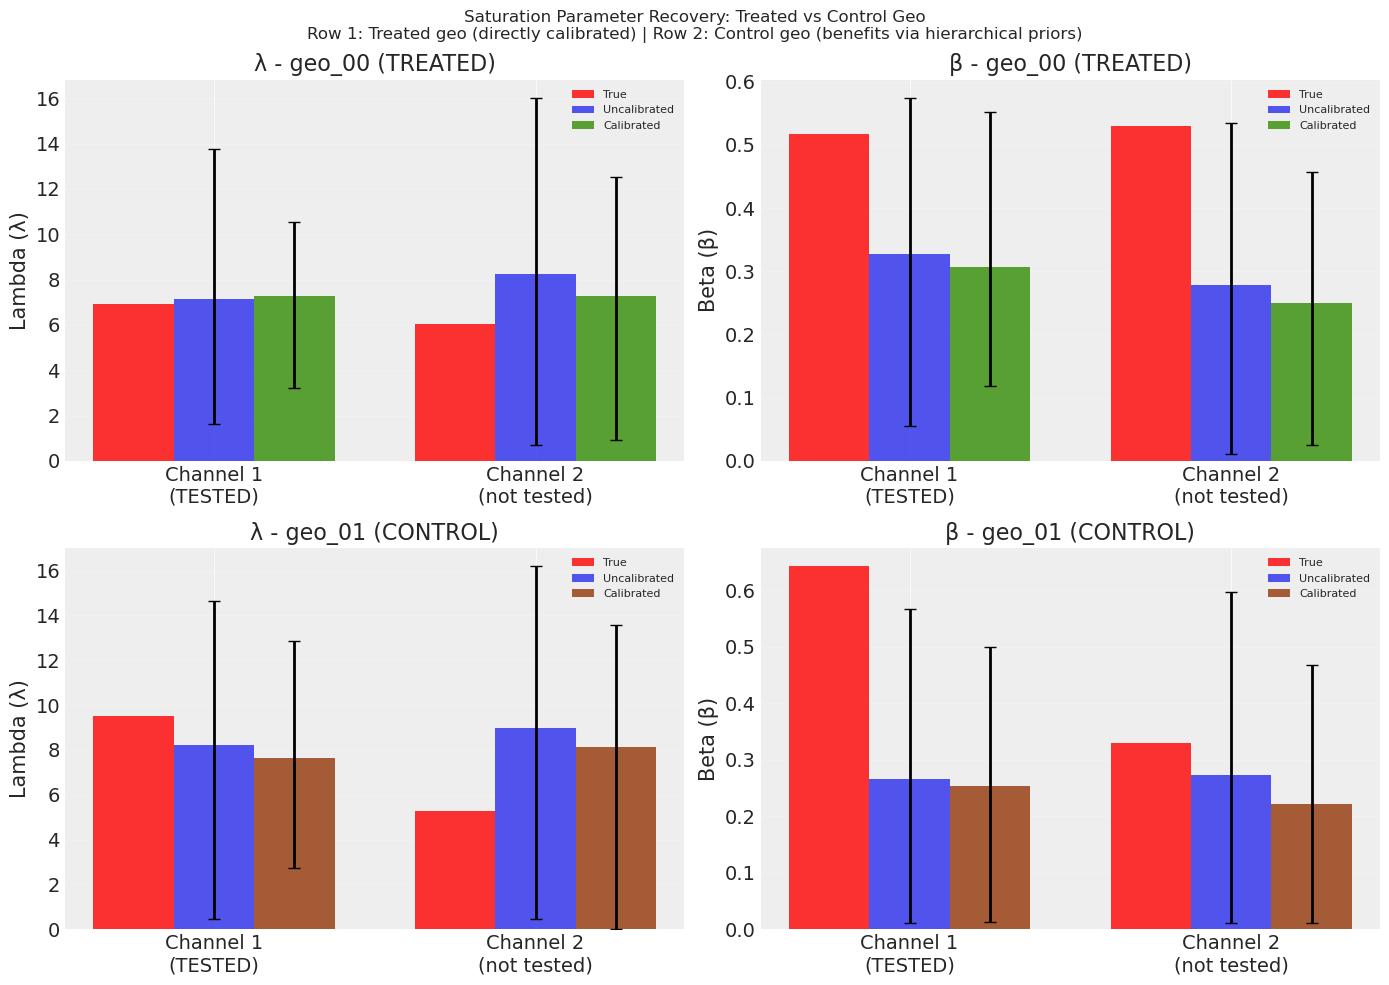


Key observations:
1. TREATED geo: Both λ and β show dramatic improvement with calibration
2. CONTROL geo: Also shows improvement, even though it wasn't directly tested!
3. This is the power of hierarchical priors: information flows through the population distribution


In [25]:
# Bar chart comparing saturation parameters: treated geo vs control geo
# This demonstrates how hierarchical priors enable information flow

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compare treated geo (directly calibrated) vs control geo (indirectly calibrated)
geo_comparisons = [
    (0, "geo_00", "TREATED"),  # Row 0: Treated geo - directly calibrated
    (1, "geo_01", "CONTROL"),  # Row 1: Control geo - indirectly calibrated
]

bar_width = 0.25
channel_labels = ["Channel 1\n(TESTED)", "Channel 2\n(not tested)"]
x_pos = np.arange(len(channel_labels))


def get_mean_and_hdi(samples, hdi_prob=0.94):
    """Extract mean and HDI bounds from posterior samples."""
    flat = samples.values.flatten()
    mean = np.mean(flat)
    hdi = az.hdi(flat, hdi_prob=hdi_prob)
    return mean, hdi[0], hdi[1]


for row, (geo_idx, geo_name, geo_type) in enumerate(geo_comparisons):
    # --- Lambda parameters (left column) ---
    ax = axes[row, 0]

    # True values for this geo
    true_lam_geo = [
        true_params["saturation_lam"][geo_idx, 0],
        true_params["saturation_lam"][geo_idx, 1],
    ]

    # Uncalibrated
    uncal_lam_stats = [
        get_mean_and_hdi(posterior_uncal["saturation_lam"][:, :, geo_idx, i])
        for i in range(2)
    ]
    uncal_lam_means = [s[0] for s in uncal_lam_stats]
    uncal_lam_err = [
        [s[0] - s[1] for s in uncal_lam_stats],
        [s[2] - s[0] for s in uncal_lam_stats],
    ]

    # Calibrated
    cal_lam_stats = [
        get_mean_and_hdi(posterior_cal["saturation_lam"][:, :, geo_idx, i])
        for i in range(2)
    ]
    cal_lam_means = [s[0] for s in cal_lam_stats]
    cal_lam_err = [
        [s[0] - s[1] for s in cal_lam_stats],
        [s[2] - s[0] for s in cal_lam_stats],
    ]

    # Plot
    ax.bar(
        x_pos - bar_width, true_lam_geo, bar_width, label="True", color="red", alpha=0.8
    )
    ax.bar(
        x_pos,
        uncal_lam_means,
        bar_width,
        label="Uncalibrated",
        color="C0",
        alpha=0.8,
        yerr=uncal_lam_err,
        capsize=4,
    )
    cal_color = "C2" if geo_type == "TREATED" else "C4"
    ax.bar(
        x_pos + bar_width,
        cal_lam_means,
        bar_width,
        label="Calibrated",
        color=cal_color,
        alpha=0.8,
        yerr=cal_lam_err,
        capsize=4,
    )

    ax.set_ylabel("Lambda (λ)")
    ax.set_title(f"λ - {geo_name} ({geo_type})")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(channel_labels)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis="y")

    # --- Beta parameters (right column) ---
    ax = axes[row, 1]

    # True values for this geo
    true_beta_geo = [
        true_params["saturation_beta"][geo_idx, 0],
        true_params["saturation_beta"][geo_idx, 1],
    ]

    # Uncalibrated
    uncal_beta_stats = [
        get_mean_and_hdi(posterior_uncal["saturation_beta"][:, :, geo_idx, i])
        for i in range(2)
    ]
    uncal_beta_means = [s[0] for s in uncal_beta_stats]
    uncal_beta_err = [
        [s[0] - s[1] for s in uncal_beta_stats],
        [s[2] - s[0] for s in uncal_beta_stats],
    ]

    # Calibrated
    cal_beta_stats = [
        get_mean_and_hdi(posterior_cal["saturation_beta"][:, :, geo_idx, i])
        for i in range(2)
    ]
    cal_beta_means = [s[0] for s in cal_beta_stats]
    cal_beta_err = [
        [s[0] - s[1] for s in cal_beta_stats],
        [s[2] - s[0] for s in cal_beta_stats],
    ]

    # Plot
    ax.bar(
        x_pos - bar_width,
        true_beta_geo,
        bar_width,
        label="True",
        color="red",
        alpha=0.8,
    )
    ax.bar(
        x_pos,
        uncal_beta_means,
        bar_width,
        label="Uncalibrated",
        color="C0",
        alpha=0.8,
        yerr=uncal_beta_err,
        capsize=4,
    )
    ax.bar(
        x_pos + bar_width,
        cal_beta_means,
        bar_width,
        label="Calibrated",
        color=cal_color,
        alpha=0.8,
        yerr=cal_beta_err,
        capsize=4,
    )

    ax.set_ylabel("Beta (β)")
    ax.set_title(f"β - {geo_name} ({geo_type})")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(channel_labels)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle(
    "Saturation Parameter Recovery: Treated vs Control Geo\n"
    "Row 1: Treated geo (directly calibrated) | Row 2: Control geo (benefits via hierarchical priors)",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("1. TREATED geo: Both λ and β show dramatic improvement with calibration")
print("2. CONTROL geo: Also shows improvement, even though it wasn't directly tested!")
print(
    "3. This is the power of hierarchical priors: information flows through the population distribution"
)

In [26]:
# Generate posterior predictive and compare
mmm_uncalibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)
mmm_calibrated.sample_posterior_predictive(X, extend_idata=True, random_seed=rng)

print("Posterior predictive samples generated")

Sampling: [y]


Output()

Sampling: [lift_measurements, y]


Output()

Posterior predictive samples generated


/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/597395768.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


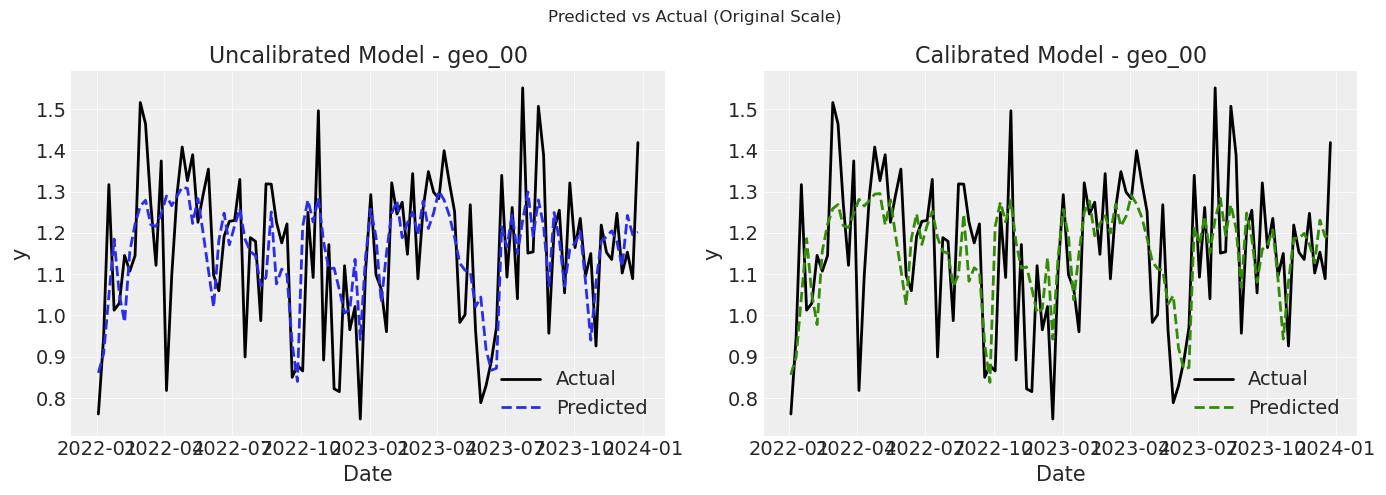

In [27]:
# Plot predicted vs actual for a sample geo
# Use a treated geo to show the direct calibration effect
focus_geo = geos[0]  # geo_00 (treated)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get predictions (in scaled space) and scale back to original space
# The model fits to scaled y, so predictions need to be multiplied by target_scale
target_scale_uncal = mmm_uncalibrated.get_scales_as_xarray()["target_scale"]
target_scale_cal = mmm_calibrated.get_scales_as_xarray()["target_scale"]

y_pred_uncal = (
    mmm_uncalibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_uncal
)
y_pred_cal = (
    mmm_calibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_cal
)

# Plot for focus geo
geo_mask = df["geo"] == focus_geo
geo_dates = df.loc[geo_mask, "date"]
y_actual = df.loc[geo_mask, "y"].values

# Uncalibrated
ax = axes[0]
y_pred_geo = y_pred_uncal.sel(geo=focus_geo).values
ax.plot(geo_dates, y_actual, "k-", label="Actual", linewidth=2)
ax.plot(geo_dates, y_pred_geo, "--", color="C0", label="Predicted", linewidth=2)
ax.set_title(f"Uncalibrated Model - {focus_geo}")
ax.set_xlabel("Date")
ax.set_ylabel("y")
ax.legend()

# Calibrated
ax = axes[1]
y_pred_geo = y_pred_cal.sel(geo=focus_geo).values
ax.plot(geo_dates, y_actual, "k-", label="Actual", linewidth=2)
ax.plot(geo_dates, y_pred_geo, "--", color="C2", label="Predicted", linewidth=2)
ax.set_title(f"Calibrated Model - {focus_geo}")
ax.set_xlabel("Date")
ax.set_ylabel("y")
ax.legend()

plt.suptitle("Predicted vs Actual (Original Scale)")
plt.tight_layout()
plt.show()

### Model Fit Comparison

An important consideration when using calibration is whether it improves parameter accuracy without sacrificing overall model fit. Let's compare the in-sample fit metrics (R² and RMSE) for both models to verify that calibration maintains good predictive performance.

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_75930/3480673614.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Model Fit Comparison (averaged across geos)
Metric            Uncalibrated     Calibrated
---------------------------------------------
R² (mean)               0.1923         0.1910
RMSE (mean)               0.15           0.15


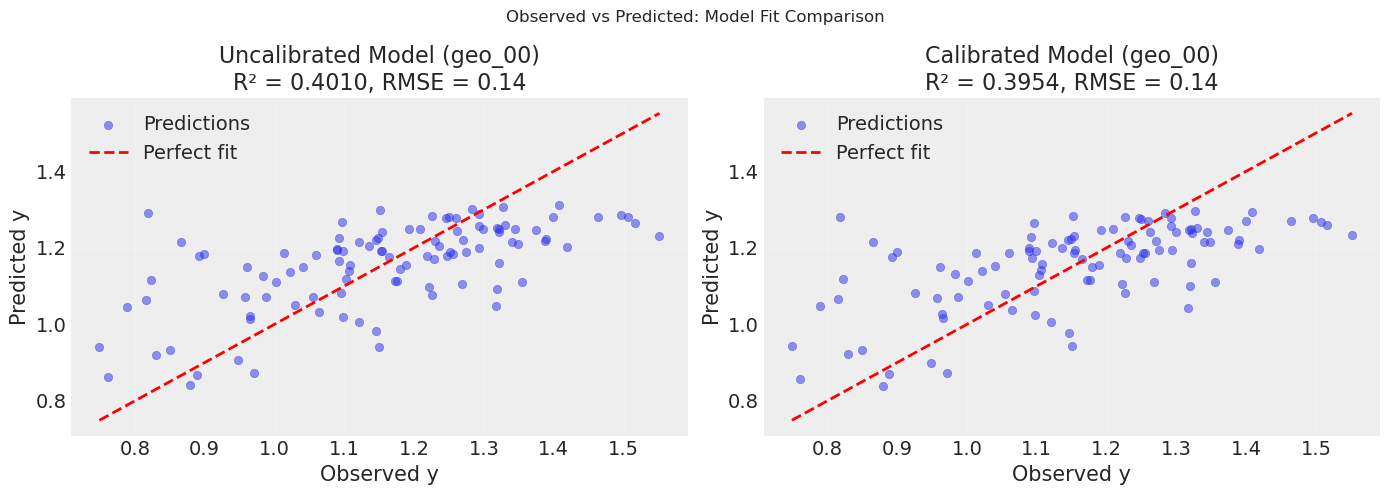

In [28]:
# Compute R² and RMSE for both models
from sklearn.metrics import r2_score, root_mean_squared_error

# Get target scales to convert predictions back to original scale
target_scale_uncal = mmm_uncalibrated.get_scales_as_xarray()["target_scale"]
target_scale_cal = mmm_calibrated.get_scales_as_xarray()["target_scale"]

# Get posterior predictive means (stay in xarray, scale to original)
y_pred_uncal_xa = (
    mmm_uncalibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_uncal
)
y_pred_cal_xa = (
    mmm_calibrated.idata.posterior_predictive["y"].mean(dim=["chain", "draw"])
    * target_scale_cal
)

# For overall metrics, compute per-geo R² and RMSE, then average
r2_uncal_list = []
r2_cal_list = []
rmse_uncal_list = []
rmse_cal_list = []

for geo in geos:
    geo_mask = df["geo"] == geo
    y_actual_geo = df.loc[geo_mask, "y"].values
    y_pred_uncal_geo = y_pred_uncal_xa.sel(geo=geo).values
    y_pred_cal_geo = y_pred_cal_xa.sel(geo=geo).values

    r2_uncal_list.append(r2_score(y_actual_geo, y_pred_uncal_geo))
    r2_cal_list.append(r2_score(y_actual_geo, y_pred_cal_geo))
    rmse_uncal_list.append(root_mean_squared_error(y_actual_geo, y_pred_uncal_geo))
    rmse_cal_list.append(root_mean_squared_error(y_actual_geo, y_pred_cal_geo))

# Average across geos
r2_uncal = np.mean(r2_uncal_list)
r2_cal = np.mean(r2_cal_list)
rmse_uncal = np.mean(rmse_uncal_list)
rmse_cal = np.mean(rmse_cal_list)

# Display results
print("Model Fit Comparison (averaged across geos)")
print("=" * 45)
print(f"{'Metric':<15} {'Uncalibrated':>14} {'Calibrated':>14}")
print("-" * 45)
print(f"{'R² (mean)':<15} {r2_uncal:>14.4f} {r2_cal:>14.4f}")
print(f"{'RMSE (mean)':<15} {rmse_uncal:>14.2f} {rmse_cal:>14.2f}")
print("=" * 45)

# Visualize observed vs predicted for a sample geo
sample_geo = treated_geos[0]
geo_mask = df["geo"] == sample_geo
y_actual_sample = df.loc[geo_mask, "y"].values
y_pred_uncal_sample = y_pred_uncal_xa.sel(geo=sample_geo).values
y_pred_cal_sample = y_pred_cal_xa.sel(geo=sample_geo).values

# Compute sample geo metrics
r2_uncal_sample = r2_score(y_actual_sample, y_pred_uncal_sample)
r2_cal_sample = r2_score(y_actual_sample, y_pred_cal_sample)
rmse_uncal_sample = root_mean_squared_error(y_actual_sample, y_pred_uncal_sample)
rmse_cal_sample = root_mean_squared_error(y_actual_sample, y_pred_cal_sample)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uncalibrated model
ax = axes[0]
ax.scatter(y_actual_sample, y_pred_uncal_sample, alpha=0.5, label="Predictions")
min_val = min(y_actual_sample.min(), y_pred_uncal_sample.min())
max_val = max(y_actual_sample.max(), y_pred_uncal_sample.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect fit")
ax.set_xlabel("Observed y")
ax.set_ylabel("Predicted y")
ax.set_title(
    f"Uncalibrated Model ({sample_geo})\n"
    f"R² = {r2_uncal_sample:.4f}, RMSE = {rmse_uncal_sample:.2f}"
)
ax.legend()
ax.grid(True, alpha=0.3)

# Calibrated model
ax = axes[1]
ax.scatter(y_actual_sample, y_pred_cal_sample, alpha=0.5, label="Predictions")
min_val = min(y_actual_sample.min(), y_pred_cal_sample.min())
max_val = max(y_actual_sample.max(), y_pred_cal_sample.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect fit")
ax.set_xlabel("Observed y")
ax.set_ylabel("Predicted y")
ax.set_title(
    f"Calibrated Model ({sample_geo})\n"
    f"R² = {r2_cal_sample:.4f}, RMSE = {rmse_cal_sample:.2f}"
)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle("Observed vs Predicted: Model Fit Comparison", fontsize=12)
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated how to calibrate a multidimensional MMM with **geo-varying parameters** using geo-level lift tests and **hierarchical priors**.

### Summary of Results

The key insight is that hierarchical priors enable **information flow** from tested to untested geos:

| Geo Type | Direct Calibration | Indirect Benefit | Result |
|----------|-------------------|------------------|--------|
| **Treated geos** (4) | Yes - lift tests directly constrain parameters | N/A | Strong improvement |
| **Control geos** (4) | No - not tested | Yes - through population parameters | Moderate improvement |
| **Untested channel** | No - only channel 1 was tested | Partial - through geo correlations | Some improvement |

*Note: See the saturation curve recovery plots above to visualize these effects.*

### Key Takeaways

1. **Geo-Level Heterogeneity Matters**:
   - Different geos have different saturation curves (varying λ and β)
   - This is realistic: markets differ in competition, demographics, and maturity
   - Each geo's saturation curve must be recovered separately

2. **Hierarchical Priors Enable Partial Pooling**:
   - Geo-level parameters are drawn from population distributions
   - Lift tests in some geos update the population parameters
   - This propagates information to **all geos**, including untested ones
   - The benefit is stronger for tested geos but extends to the whole model

3. **The Problem**: Without lift tests, highly correlated channels and geo-level variation make parameter recovery difficult

4. **The Solution**: Geo-level lift tests + hierarchical priors:
   - Directly constrain tested geos' saturation curves
   - Indirectly improve untested geos through shared population parameters
   - Result: better parameter recovery across the entire model

### What This Means for Practitioners

When designing geo-level experiments:
- **You don't need to test every geo** - hierarchical structure shares information
- **More tested geos = better population estimates** - but diminishing returns
- **Strategic selection matters** - test geos that represent the population well
- **Both channels benefit** - even untested channel 2 improves through correlations

### Practical Application

In practice:
1. **Design geo-level experiments** with treated and control regions
2. **Conduct experiments** with increased (or decreased) spend on target channel
3. **Analyze with CausalPy** using synthetic control to get lift estimates (`delta_y`, `sigma`)
4. **Format as DataFrame** with columns: `[channel, geo, x, delta_x, delta_y, sigma]`
5. **Use hierarchical priors** for saturation parameters (as shown in this notebook)
6. **Add lift tests to MMM**: `mmm.add_lift_test_measurements(df_lift_test)`

### References

- [CausalPy Multi-Cell GeoLift](https://causalpy.readthedocs.io/en/latest/notebooks/multi_cell_geolift.html) - for synthetic control analysis
- [PyMC-Marketing National-Level Lift Tests](mmm_lift_test.ipynb) - simpler single-geo case
- [PyMC-Marketing Multidimensional MMM](mmm_multidimensional_example.ipynb) - geo-level modeling basics
- [Model Configuration Guide](../general/model_configuration.ipynb) - hierarchical prior specification